<a href="https://colab.research.google.com/github/arash-am/Media-Competition/blob/main/Main/Online_Version_Parallel_Computing_QRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # used for arrays
import gym # pull the environment
import time # to get the times
import math # needed for calculations
import torch
import matplotlib.pyplot as plt
import time  # Import the time module for timing
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Payoff_mat'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/gdrive
/content/gdrive/MyDrive/UT/Credit-Bias Project/Payoff_mat


# Cuda

In [ ]:
import torch
import torch.multiprocessing as mp
import time
import numpy as np

class Opinon_w_media_9(torch.nn.Module):
    def __init__(self, device, N=1000, M=10, terminal_time=500,
                 bM=5, b=25, noise_level=0.1, duration=50, eta=1, eta2=2,
                 h=torch.tensor(0.1),num_batches=10,bet1=3,bet2=2):
        super().__init__()
        self.batch_size = num_batches
        self.device = device
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        Beta = torch.distributions.beta.Beta(bet1, bet2)
        self.s = Beta.sample(sample_shape=(self.N,self.batch_size)).to(self.device)
        self.ym = torch.linspace(-1, 1, steps=self.M).to(self.device)
        self.noise_level = noise_level
        self.bM = bM
        self.b = b
        self.duration = duration
        self.eta = eta
        self.eta2 = eta2
        self.h = h.to(self.device)
        self.t=0
        self.action_dim=9
        self.pi=torch.tensor(np.pi,device=self.device)

    def action_list(self, action_ids):
        zm = torch.linspace(0, 1, steps=int(self.M/2)).to(self.device)
        action_ids = action_ids.unsqueeze(1)
        zm_batch = zm.expand(action_ids.size(0), -1)
        # probabilities = torch.tensor([.9, .9, .1, .1], device=self.device)
        # deltas = torch.tensor([.000001, .8, -.8, -.00001], device=self.device)


        probabilities = torch.tensor([.95, .95, .95, .5, .5, .1, .1, .5, .1], device=self.device)
        deltas = torch.tensor([.000001, .85, .45, -.00001, -.45, -.85, -.0000001, .4, -.4], device=self.device)
        #
        # Calculate the base probability matrix from action_ids mapping
        base_probs = probabilities[action_ids].squeeze()
        delta_probs = deltas[action_ids].squeeze()

        return torch.bernoulli(base_probs-zm[:,None]*delta_probs)



    def reset(self):
        self.state = torch.cat([torch.rand((self.N,self.batch_size), device=self.device) * 2 - 1,
                                torch.ones((self.M,self.batch_size), device=self.device)])
        return self.state

    def dyn_step(self, u_action_ids, v_action_ids):
        rewards = torch.zeros((self.batch_size,), device=self.device)
        dones = torch.zeros((self.batch_size,), device=self.device, dtype=torch.bool)
        x, c= self.state[:self.N], self.state[self.N:]
        t=self.t
        gam=0.98
        rewards=0
        # AE=torch.zeros((self.batch_size,self.M,self.N),device=self.device)
        for i in range(self.terminal_time):
            DM = self.ym-x[:,:,None]
            D = x - x[:, None]
            u_actions = self.action_list(u_action_ids).t()
            v_actions = self.action_list(v_action_ids).t()
            actions = torch.cat([u_actions, v_actions],dim=1)
            eta = self.eta
            eta2 = self.eta2
            AM = torch.exp(-self.bM * (1 + eta * actions[None,:,:]) * (1 + eta2 * (1 - c.t()[None,:,:])*(1-self.s[:,:,None])) * torch.abs(DM))
            #Exposure to misinformation
            # AE = torch.exp(-self.bM * (1 + eta * actions[None,:,:]) * (1 + eta2 * (1 - c.t()[None,:,:])*(1-self.s[:,:,None])) * torch.abs(DM))* actions[None,:,:]
            A = torch.exp(-self.b * torch.abs(D))
            t += 1
            # c = (c * (t - 1) + actions.t()) / t
            c= c*(gam)+actions.t()*(1-gam)
            x += self.h * ((torch.sum(A * D, dim=1) / torch.sum(A, dim=1)) + (torch.sum(AM * DM, dim=2) / torch.sum(AM, dim=2)))
            x += torch.sqrt(self.h) * torch.normal(0, self.noise_level, size=(self.N,self.batch_size), device=self.device)
            rewards += -1*torch.sin(x*self.pi/2).pow(5).sum().to(self.device)
        self.state=torch.cat([x,c])
        # print(c.mean(dim=1))
        self.t=t
        dones = dones | (t >= self.terminal_time)
        return rewards, dones




# Tests

#Action Plots

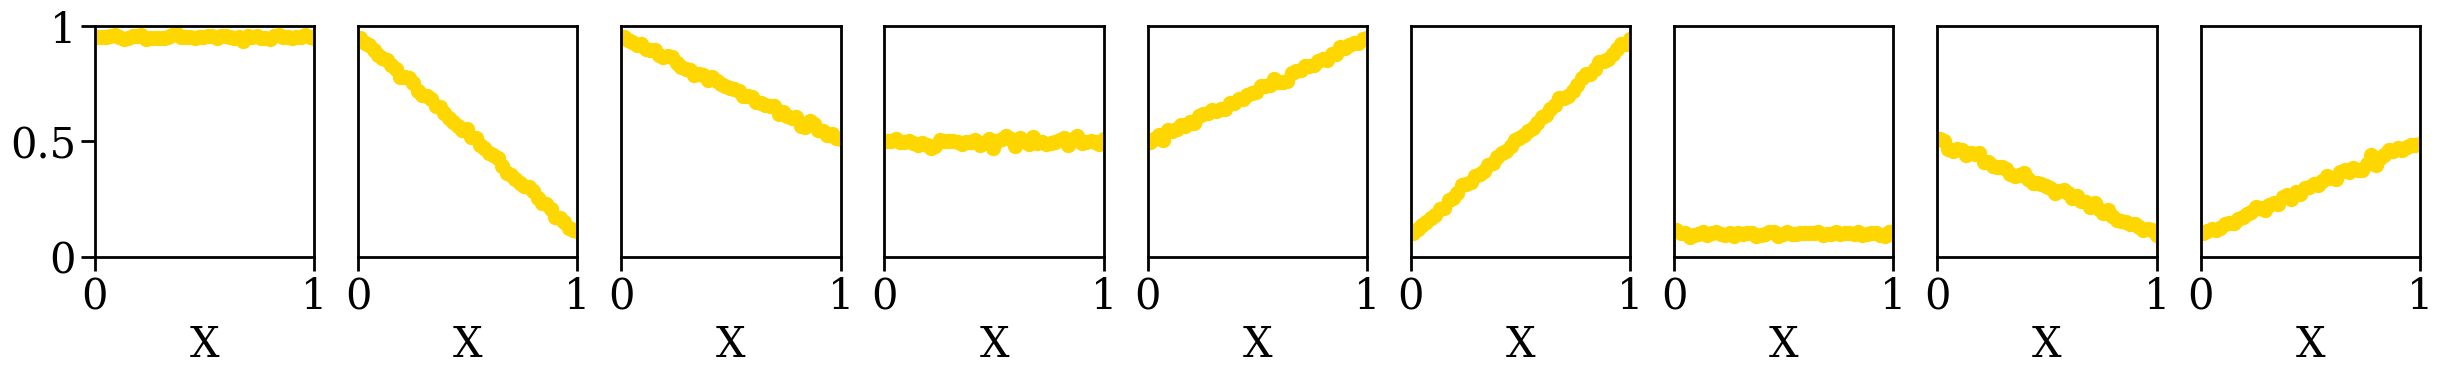

In [ ]:
M=100
N=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
terminal_time=1000
eta=1
eta2=2
env = Opinon_w_media_9(device=device, N=N,
                              M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                              duration=terminal_time,h=torch.tensor(.1),
                              num_batches=2000,eta=eta, eta2=eta2,
                              bet1=3,bet2=2)
import matplotlib.pyplot as plt
import torch

# Assuming env, device, and other necessary elements are already defined.
plt.rc('font', family='serif', size=30)

# Create a figure with subplots in a 3x3 grid
fig, axes = plt.subplots(1, 9, figsize=(30, 3))#, gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

# Flatten the axes array for easy looping (since axes is now a 2D array)
axes = axes.flatten()

# Loop over i values from 0 to 8
for i in range(9):
    # Plotting on the i-th subplot
    ax = axes[i]
    scatter_data = env.action_list((i * torch.ones((env.batch_size,), device=device)).long()).mean(dim=1)
    ax.scatter(env.ym[int(env.M/2):].cpu(), scatter_data.cpu(), 100, alpha=1,c='gold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    # ax.set_xticklabels([0,1])
    ax.set_xticks([0,1])
    ax.set_xlabel('X')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(axis='x', which='major', labelsize=30, width=2, length=10)
    ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
    # Hide y-ticks and labels for all but the first plot in the top left
    if i !=0:
        ax.set_yticklabels([])
        ax.set_yticks([])

    # Optionally, you can also remove x-ticks for all but the bottom row plots
    if i == 0:
        ax.set_yticks([0,0.5,1],[0,0.5,1])


# Display the plot
plt.savefig('action_space.svg',dpi=300)
plt.show()


#Pay off matrix

In [ ]:

def run_simulation(i, j,env):
    env.reset()
    # print(i,j)
    # reward, done = env.dyn_step(torch.randint(env.action_dim,(env.batch_size,),device=env.device), torch.randint(env.action_dim,(env.batch_size,),device=env.device))
    reward, done = env.dyn_step(i*torch.ones((env.batch_size),device=device,dtype=torch.int32), j*torch.ones((env.batch_size),device=device,dtype=torch.int32))
    return reward.mean().item()

M=10
N=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
terminal_time=300
for eta in tqdm(np.arange(1,2.1,0.1), desc='Outer Loop Progress'):
    for eta2 in np.arange(3,6,0.1):
        env = Opinon_w_media_9(device=device, N=N,
                                        M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                                        duration=terminal_time,h=torch.tensor(.1),
                                        num_batches=100,eta=eta, eta2=eta2,
                                        bet1=3,bet2=2)
        A = torch.zeros((env.action_dim, env.action_dim),device=device)
        for i in range(env.action_dim):
            for j in range(env.action_dim):
                    A[i,j]=run_simulation(i, j,env)
                    # print(i,j,A[i,j])
        save_file='Payoff-eta_'+str(eta)+'eta_2'+str(eta2)+'.pt'
        torch.save(A, save_file)
        print(save_file)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def run_simulation(i, j,env):
    env.reset()
    # print(i,j)
    # reward, done = env.dyn_step(torch.randint(env.action_dim,(env.batch_size,),device=env.device), torch.randint(env.action_dim,(env.batch_size,),device=env.device))
    reward, done = env.dyn_step(i*torch.ones((env.batch_size),device=device,dtype=torch.int32), j*torch.ones((env.batch_size),device=device,dtype=torch.int32))
    return reward.mean().item()


def plotter(env,text_type='beta'):
    plt.rc('font', family='serif', size=20)
    x, s = env.state[:N, :].cpu().flatten().numpy(), env.s.cpu().flatten().numpy()
    data = np.array([[bias, susceptibility] for bias, susceptibility in zip(x, s)])
    df = pd.DataFrame(data, columns=['Opinion Bias', 'Susceptibility'])

    # Define bins and filter data
    bins = np.arange(-1, 1.1, 0.1)
    df['Bin'] = pd.cut(df['Opinion Bias'], bins=bins, include_lowest=True)
    bin_counts = df.groupby('Bin').size()
    valid_bins = bin_counts[bin_counts >= 5].index
    filtered_df = df[df['Bin'].isin(valid_bins)]
    mean_susceptibility = filtered_df.groupby('Bin')['Susceptibility'].mean().reset_index()
    mean_susceptibility['Midpoint'] = mean_susceptibility['Bin'].apply(lambda x: x.mid)


    g = sns.JointGrid(height=10)
    g.ax_joint.scatter(x,s,1,c=x,cmap=plt.cm.coolwarm,alpha=1)
    sns.kdeplot(x, color="gray", fill=True, ax=g.ax_marg_x)
    g.ax_joint.set_xlim([-1, 1])
    g.ax_joint.set_ylim([0.1, 1])
    g.ax_marg_y.remove()
    for _, spine in g.ax_joint.spines.items():
        spine.set_visible(True)

    # Plot mean susceptibility
    g.ax_joint.plot(mean_susceptibility['Midpoint'], mean_susceptibility['Susceptibility'], color='black', linestyle='-', label='Mean Susceptibility', linewidth=3, alpha=.5)
    g.ax_joint.set_xticks([-1,0,1])
    g.ax_joint.set_yticks([0,0.5,1])

    g.ax_joint.set_xlim([-1.1,1.1])
    g.ax_joint.set_ylim([-.1,1.1])
    # Define the inset axes for the scatter plot
    # ax_inset = inset_axes(g.ax_joint, width="30%", height="30%", loc='lower right')
    ax_inset = inset_axes(g.ax_joint, width="25%", height="25%", loc='lower right', bbox_to_anchor=(-0.03, 0.03, 1, 1), bbox_transform=g.ax_joint.transAxes)
    # Scatter plot for the inset
    cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
    sc = ax_inset.scatter(env.ym.cpu(), env.state[N:, :].cpu().mean(dim=1),
                          50,
                          c=env.ym.cpu(), cmap=cmap, alpha=1)
    ax_inset.tick_params(axis='both', which='major', labelsize=14)  # Adjust tick sizes if needed
    ax_inset.set_xticks([-1,0,1])
    ax_inset.set_yticks([0,0.5,1])
    ax_inset.set_xlim([-1.1, 1.1])
    ax_inset.set_ylim([-0.02, 1.02])
    # ax_inset.grid(True)
    # plt.savefig(text_type+str(env.eta)+'_'+str(env.eta2)+'.eps',dpi=300)
    # plt.savefig(text_type+str(env.eta)+'_'+str(env.eta2)+'.png',dpi=300)
    plt.show()






def QRE(A,taw=0.1):
    Ar=A/A.abs().max()
    mu=torch.softmax(torch.rand((Ar.shape[0],1),device=device),dim=0)
    nu=torch.softmax(torch.rand((Ar.shape[0],1),device=device),dim=0)
    mub=mu
    nub=nu
    eta=taw/10
    for i in range(3*10**4):
        mut=mu
        nut=nu
        mub=mu.pow(1-eta*taw)*torch.exp(eta*Ar@nub)/(mu.pow(1-eta*taw)*torch.exp(eta*Ar@nub)).sum()
        nub=nu.pow(1-eta*taw)*torch.exp(-eta*Ar.t()@mub)/(nu.pow(1-eta*taw)*torch.exp(-eta*Ar.t()@mub)).sum()
        mu=mu.pow(1-eta*taw)*torch.exp(eta*Ar@nub)/(mu.pow(1-eta*taw)*torch.exp(eta*Ar@nub)).sum()
        nu=nu.pow(1-eta*taw)*torch.exp(-eta*Ar.t()@mub)/(nu.pow(1-eta*taw)*torch.exp(-eta*Ar.t()@mub)).sum()
        DG=nut.t()@Ar@mu-nu.t()@Ar@mut
        # if i%10000==0:
          # print(f"Dulity Gap taw {i:.0f}: {DG.item():.2e}")
        if DG.abs().item()< 1e-7:
          print(f"Dulity Gap taw {i:.0f}: {DG.item():.2e}")
          break
    return mu,nu





# eta - xi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Outer Loop Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Dulity Gap taw 1797: 8.57e-08


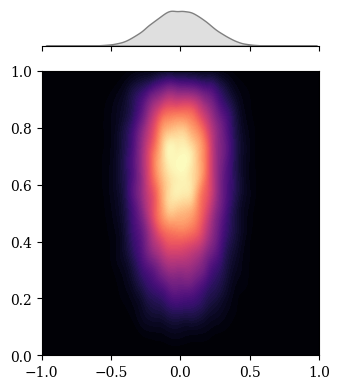

Dulity Gap taw 3575: -9.69e-08


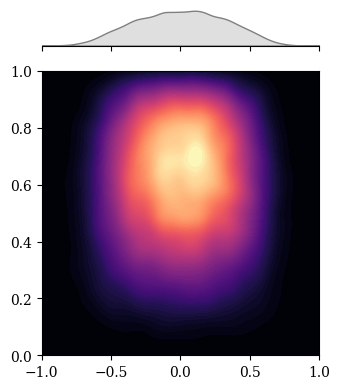

Dulity Gap taw 4737: -9.66e-08


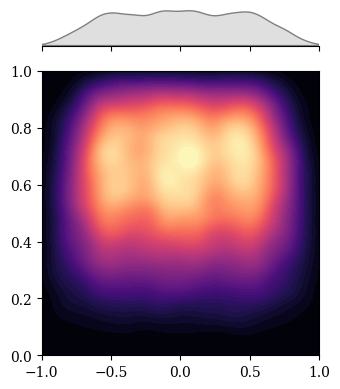

Dulity Gap taw 318: -2.24e-08


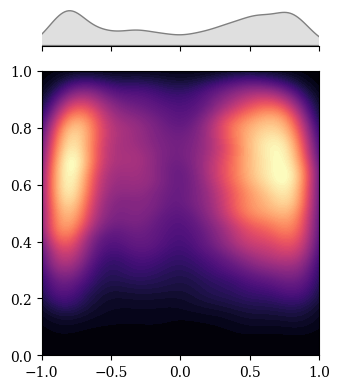

Outer Loop Progress:  25%|██▌       | 1/4 [02:25<07:15, 145.28s/it]

Dulity Gap taw 5952: -9.96e-08


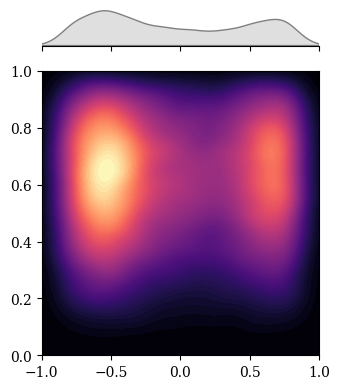

Dulity Gap taw 5339: 9.92e-08


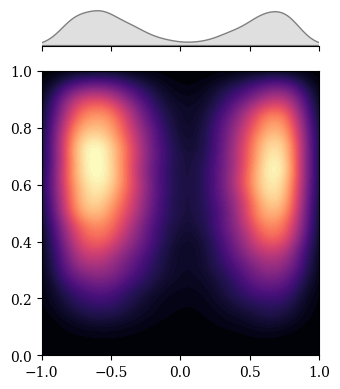

Dulity Gap taw 58: 7.82e-08


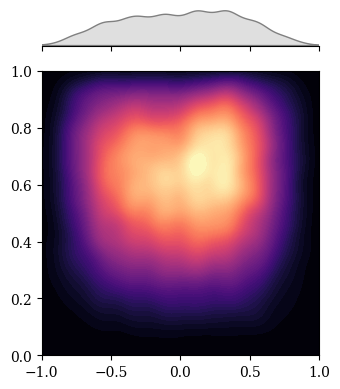

Dulity Gap taw 4687: 9.78e-08


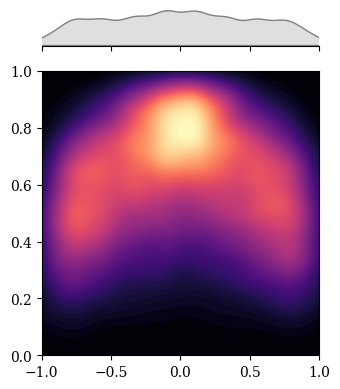

Outer Loop Progress:  50%|█████     | 2/4 [04:49<04:49, 144.87s/it]

Dulity Gap taw 599: -8.57e-08


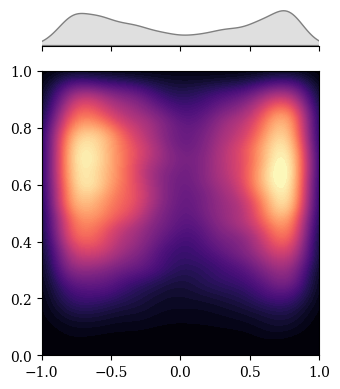

Dulity Gap taw 5860: 9.69e-08


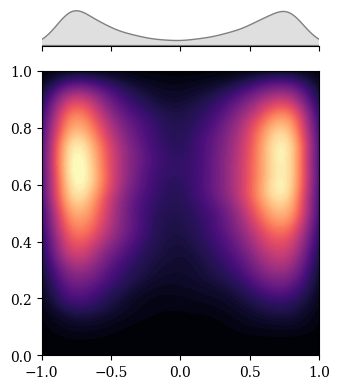

Dulity Gap taw 6744: 9.97e-08


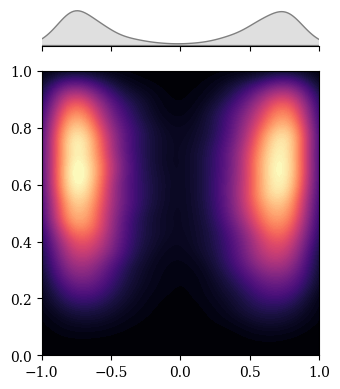

Dulity Gap taw 6966: 9.97e-08


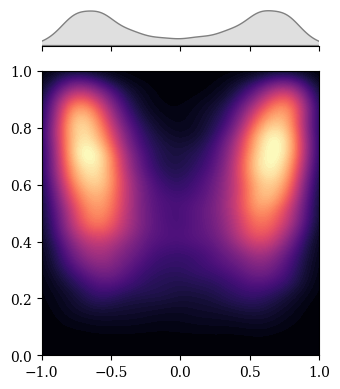

Outer Loop Progress:  75%|███████▌  | 3/4 [07:17<02:26, 146.04s/it]

Dulity Gap taw 1202: -9.62e-08


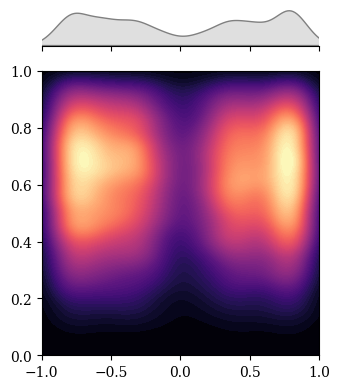

Dulity Gap taw 5939: 9.92e-08


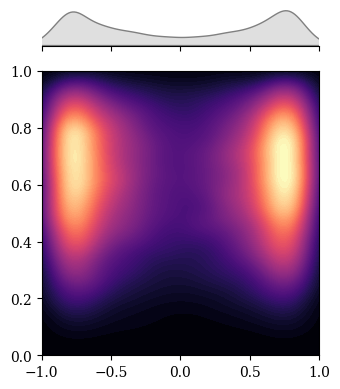

Dulity Gap taw 6270: 9.87e-08


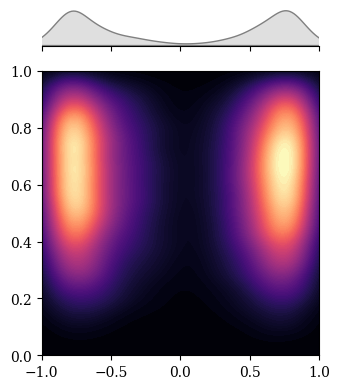

Dulity Gap taw 6678: 9.97e-08


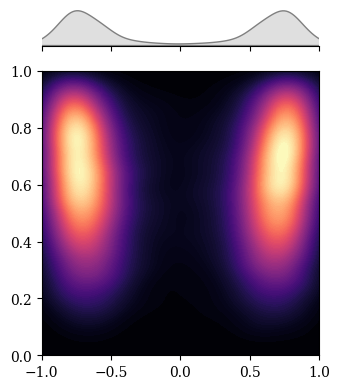

Outer Loop Progress: 100%|██████████| 4/4 [09:43<00:00, 145.90s/it]


In [ ]:
M=10
N=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rc('font', family='serif', size=10)
terminal_time=1000
for eta in tqdm([0,1,2,4], desc='Outer Loop Progress'):
    for eta2 in [0,1,2,4]:
        A=torch.load('Payoff-eta_'+str(eta)+'eta_2'+str(eta2)+'.pt')#,map_location=torch.device('cpu'))
        mu,nu=QRE(A,taw=.1)
        env = Opinon_w_media_9(device=device, N=N,
                                        M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                                        duration=terminal_time,h=torch.tensor(.1),
                                        num_batches=100,eta=eta, eta2=eta2,
                                        bet1=3,bet2=2)
        run_simulation(torch.multinomial((mu / mu.sum()).view(-1), num_samples=env.batch_size, replacement=True), torch.multinomial((nu / nu.sum()).view(-1), num_samples=env.batch_size, replacement=True),env)
        x=env.state[:N].cpu().numpy()
        s=env.s.cpu().numpy()
        c=env.state[N:]
        g = sns.JointGrid(height=4)
        sns.kdeplot(x=x.flatten(), y=s.flatten(), fill=True, thresh=None, cmap="magma", levels=100, ax=g.ax_joint)
        sns.kdeplot(x=x.flatten(), color="gray", fill=True, ax=g.ax_marg_x)
        g.ax_joint.set_xlim([-1, 1])
        g.ax_joint.set_ylim([0, 1])
        g.ax_marg_y.remove()
        for _, spine in g.ax_joint.spines.items():
            spine.set_visible(True)
        plt.tight_layout()
        plt.savefig("xs_kde4"+str(eta)+'_'+str(eta2)+".svg",dpi=300)
        plt.show()



Dulity Gap taw 6711: 9.87e-08


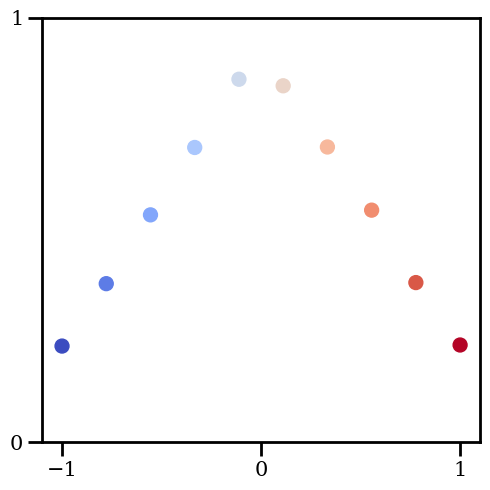

In [ ]:
M=10
N=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rc('font', family='serif', size=10)
terminal_time=1000

# for eta in tqdm([0,1,2,4], desc='Outer Loop Progress'):
#     for eta2 in [0,1,2,4]:
eta=4
eta2=4


A=torch.load('Payoff-eta_'+str(eta)+'eta_2'+str(eta2)+'.pt')#,map_location=torch.device('cpu'))
mu,nu=QRE(A,taw=.1)
env = Opinon_w_media_9(device=device, N=N,
                                M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                                duration=terminal_time,h=torch.tensor(.1),
                                num_batches=100,eta=eta, eta2=eta2,
                                bet1=3,bet2=2)
run_simulation(torch.multinomial((mu / mu.sum()).view(-1), num_samples=env.batch_size, replacement=True), torch.multinomial((nu / nu.sum()).view(-1), num_samples=env.batch_size, replacement=True),env)
x=env.state[:N].cpu().numpy()
s=env.s.cpu().numpy()
c=env.state[N:].cpu()
# g = sns.JointGrid(height=4)
# sns.kdeplot(x=x.flatten(), y=s.flatten(), fill=True, thresh=None, cmap="magma", levels=100, ax=g.ax_joint)
# sns.kdeplot(x=x.flatten(), color="gray", fill=True, ax=g.ax_marg_x)
# g.ax_joint.set_xlim([-1, 1])
# g.ax_joint.set_ylim([0, 1])
# g.ax_marg_y.remove()
# for _, spine in g.ax_joint.spines.items():
#     spine.set_visible(True)
# plt.tight_layout()
# # plt.savefig("xs_kde4"+str(eta)+'_'+str(eta2)+".svg",dpi=300)
# plt.show()

cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
# cmap = plt.cm.RdYlBu_r
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(env.ym.cpu(),c.mean(dim=1),100,c=env.ym.cpu(),cmap=cmap,alpha=1)
ax.set_xlim([-1.1 ,1.1])
ax.set_ylim([0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.savefig("x_cr-f"+str(eta)+'_'+str(eta2)+".svg",dpi=300)
plt.show()


In [ ]:
def Generator(eta1,eta2):
    A=torch.load('Payoff-eta_'+str(eta1)+'eta_2'+str(eta2)+'.pt')#,map_location=torch.device('cpu'))
    M=10
    N=500
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    plt.rc('font', family='serif', size=18)
    terminal_time=200
    mu,nu=QRE(A,taw=0.1)
    env = Opinon_w_media_9(device=device, N=N,
                                    M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                                    duration=terminal_time,h=torch.tensor(.1),
                                    num_batches=100,eta=eta1, eta2=eta2,
                                    bet1=3,bet2=2)
    run_simulation(torch.multinomial((mu / mu.sum()).view(-1), num_samples=env.batch_size, replacement=True),
                  torch.multinomial((nu / nu.sum()).view(-1), num_samples=env.batch_size, replacement=True),
                  env)
    x, s = env.state[:N, :].cpu().flatten().numpy(), env.s.cpu().flatten().numpy()
    return x,s
def run_simulation(i, j,env):
    env.reset()
    reward, done = env.dyn_step(i*torch.ones((env.batch_size),device=device,dtype=torch.int32), j*torch.ones((env.batch_size),device=device,dtype=torch.int32))
    return reward.mean().item()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dulity Gap taw 0: 1.90e-05
Dulity Gap taw 1724: 9.69e-08
Dulity Gap taw 0: -7.04e-04
Dulity Gap taw 3563: -9.87e-08
Dulity Gap taw 0: -3.91e-04
Dulity Gap taw 4659: -9.08e-08
Dulity Gap taw 0: -2.40e-04
Dulity Gap taw 5832: -9.91e-08
Dulity Gap taw 0: -2.05e-04
Dulity Gap taw 4836: 9.97e-08
Dulity Gap taw 0: -1.54e-04
Dulity Gap taw 5743: 9.50e-08
Dulity Gap taw 0: -2.49e-04
Dulity Gap taw 3863: -9.76e-08
Dulity Gap taw 0: 7.84e-05
Dulity Gap taw 6325: 9.87e-08
Dulity Gap taw 0: 1.09e-04
Dulity Gap taw 6611: 9.97e-08


<ipython-input-18-cf46790f44bb>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


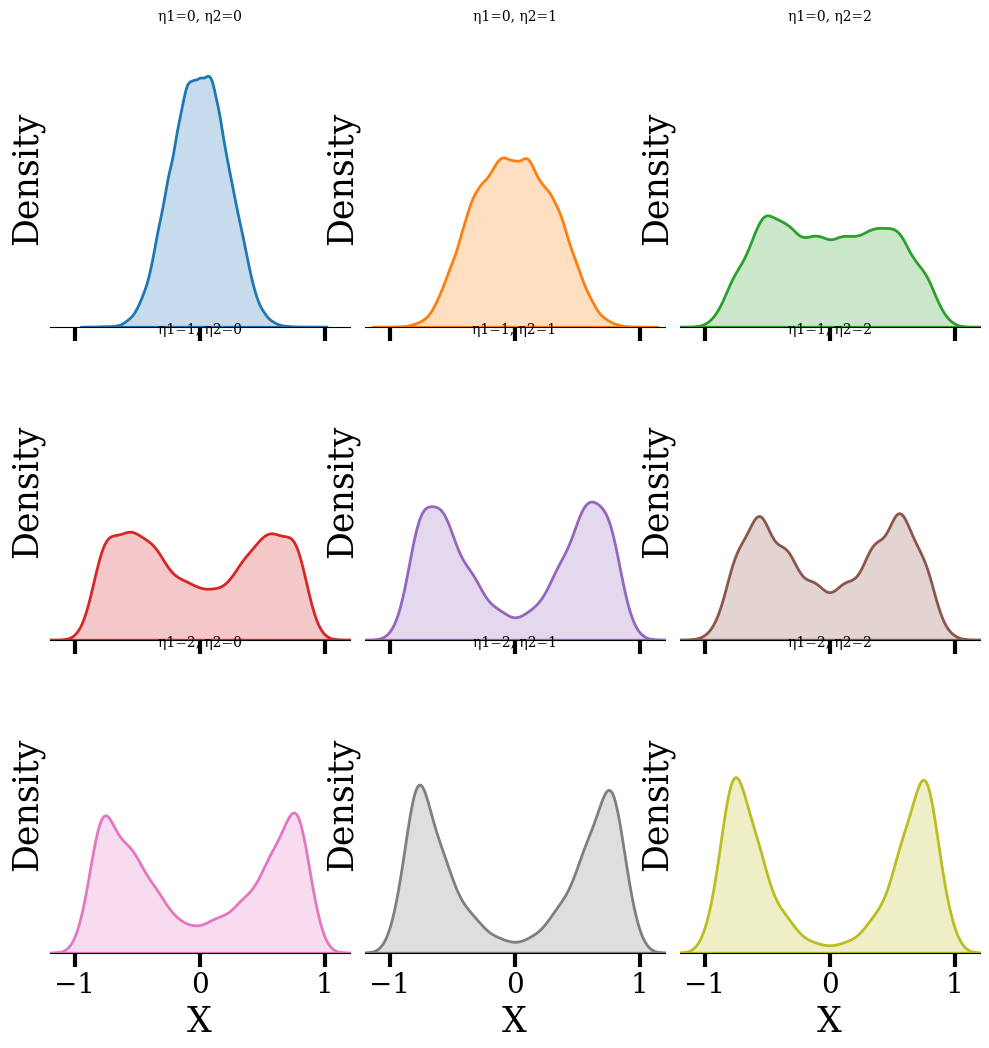

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rc('font', family='serif', size=25)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Example data
pre_rdn_data = np.random.normal(0, 1, 1000)
post_rdn_data = np.random.normal(0, 2, 1000)
rdn_off_data = np.random.normal(0, 0.5, 1000)


# Create the figure and axes

numeplt=3
palette = sns.color_palette("tab10", numeplt**2)
fig, axes = plt.subplots(numeplt, numeplt, figsize=(numeplt*4, numeplt*4),gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
# Plotting KDE plots


Eta1=[0,1,2,4,8]
Eta2=[0,1,2,4,8]
# x,s=Generator(Eta1[i],Eta2[j])


for i in range(numeplt):
  for j in range(numeplt):
    x,s=Generator(Eta1[i],Eta2[j])
    ax=axes[i,j]
    sns.kdeplot(x=x, color=palette[i*numeplt+j], ax=ax, fill=True,linewidth=2)
    ax.set_title(ax.get_title(), fontsize=10)
    ax.set_xlabel('X')
    ax.set_ylabel('Density')
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f"η1={Eta1[i]}, η2={Eta2[j]}", fontsize=10)
    # Remove y-axis tick marks
    ax.set_xlim([-1.2,1.2])
    ax.set_ylim([0,2])
    ax.tick_params(axis='x', which='major', labelsize=20, width=3, length=10)
    ax.xaxis.set_ticks([-1 ,0 , 1])
    ax.yaxis.set_ticks([])


# Display the plot
plt.savefig("finaldists"+str(numeplt)+".svg",dpi=300)
plt.savefig("finaldists"+str(numeplt)+".eps",dpi=300)
plt.savefig("finaldists"+str(numeplt)+".png",dpi=300)
plt.tight_layout()
plt.show()


# Tau- Rationality

Dulity Gap taw 0: -2.42e-04
Dulity Gap taw 6025: -9.64e-08
Dulity Gap taw 0: -2.91e-04
Dulity Gap taw 4452: 9.87e-08
Dulity Gap taw 0: -1.02e-04
Dulity Gap taw 6059: 9.69e-08
Dulity Gap taw 0: 3.78e-04
Dulity Gap taw 4666: 9.87e-08
Dulity Gap taw 0: 1.13e-03
Dulity Gap taw 4250: 9.99e-08
Dulity Gap taw 0: -4.77e-04
Dulity Gap taw 5522: -9.79e-08
Dulity Gap taw 0: -1.61e-04
Dulity Gap taw 169: -6.80e-08
Dulity Gap taw 0: -1.79e-04
Dulity Gap taw 5904: 9.87e-08
Dulity Gap taw 0: 4.22e-04
Dulity Gap taw 4723: 9.78e-08
Dulity Gap taw 0: 9.10e-04
Dulity Gap taw 4115: 9.80e-08
Dulity Gap taw 0: -2.24e-04
Dulity Gap taw 5794: -9.55e-08
Dulity Gap taw 0: -1.67e-04
Dulity Gap taw 198: 1.86e-09
Dulity Gap taw 0: -7.86e-05
Dulity Gap taw 5785: 9.50e-08
Dulity Gap taw 0: 4.80e-04
Dulity Gap taw 4733: 9.97e-08
Dulity Gap taw 0: 1.14e-03
Dulity Gap taw 4165: 9.95e-08
Dulity Gap taw 0: -3.87e-04
Dulity Gap taw 5950: -9.91e-08
Dulity Gap taw 0: -2.97e-04
Dulity Gap taw 360: 3.54e-08
Dulity Gap taw 0: 

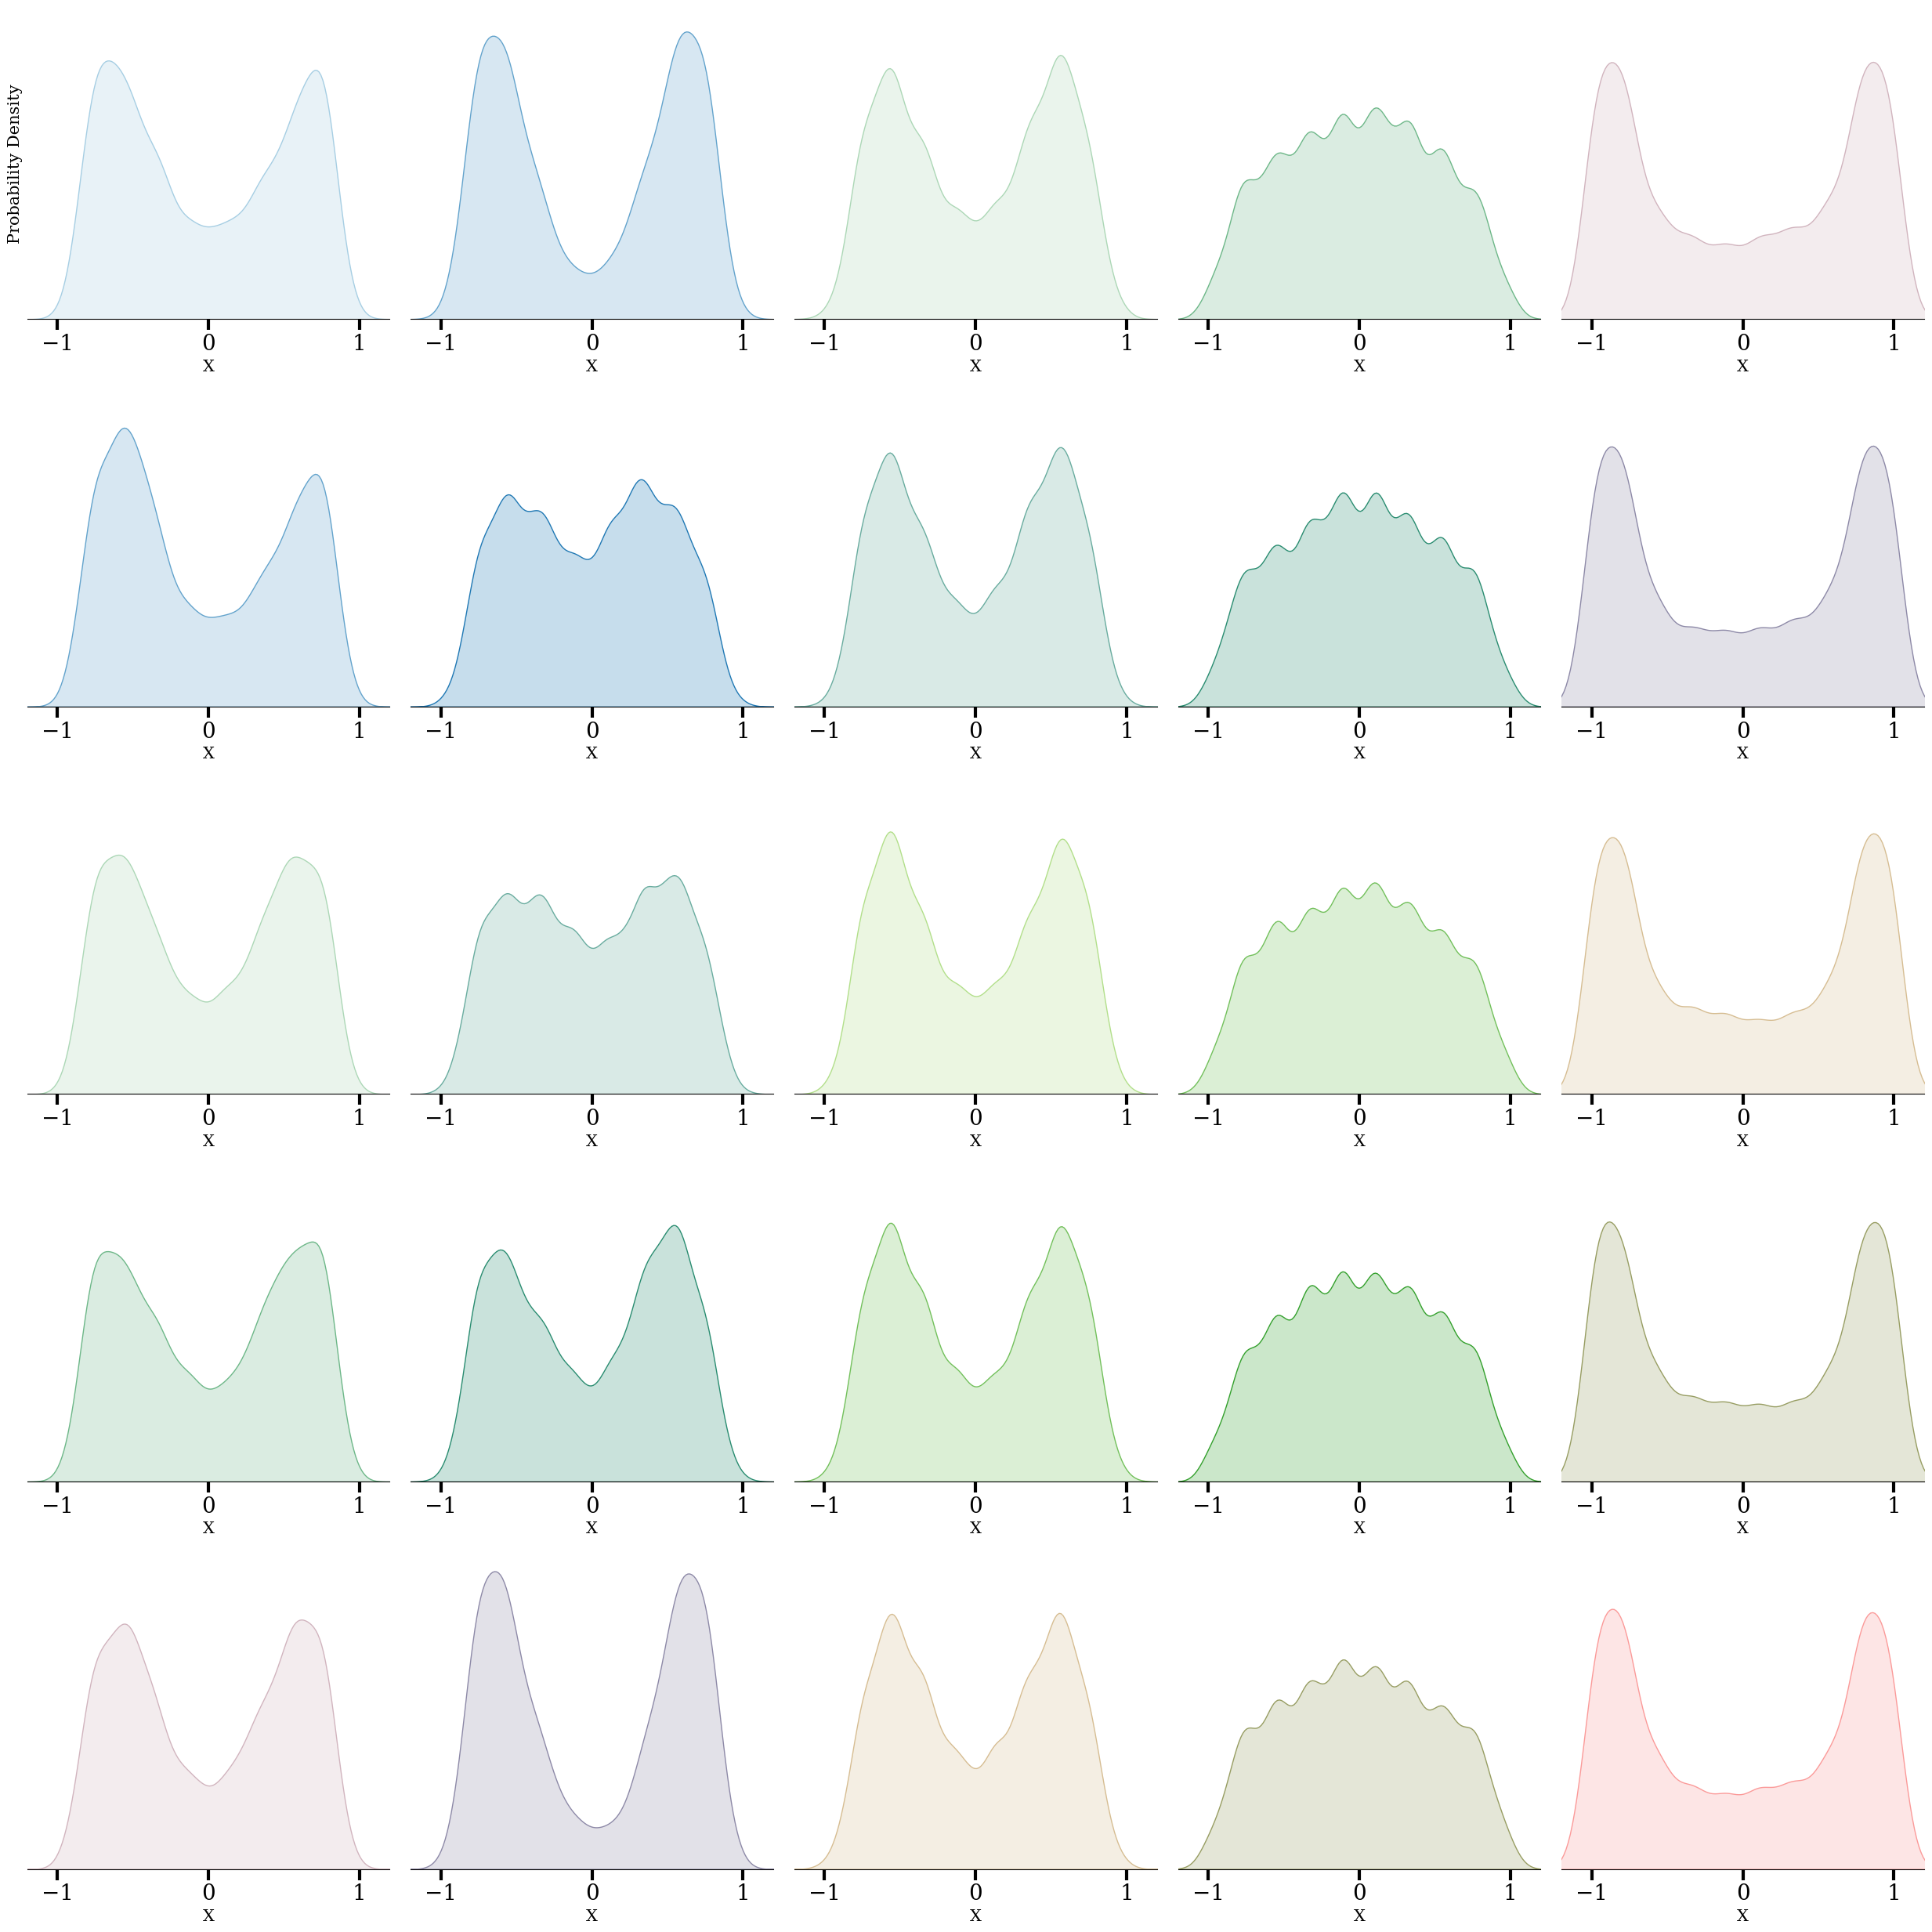

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rc('font', family='serif', size=15)

# Example data generation function (assuming this function exists)

# Set up the number of plots and dimensions
numeplt = 5
size_plot=5
fig, axes = plt.subplots(numeplt, numeplt, figsize=(numeplt*size_plot, numeplt*size_plot), sharey=True)

# Define parameters for varying
Eta1 = [0, 1, 2, 4, 8]
Eta2 = [0, 1, 2, 4, 8]

# Generate a color palette for rows and columns
base_colors_rows = sns.color_palette("Paired", numeplt)
base_colors_cols = sns.color_palette("Paired", numeplt)
# x, s = Generator(Eta1[i], Eta2[j])
for i in range(numeplt):
    for j in range(numeplt):
        x, s = Generator(Eta1[i], Eta2[j])
        ax = axes[i, j]

        # Interpolate between row and column base colors to mix them
        row_color = np.array(base_colors_rows[i])
        col_color = np.array(base_colors_cols[j])
        mixed_color = (row_color + col_color) / 2  # Simple average to mix colors

        # Plotting
        sns.kdeplot(x=x, color=mixed_color, ax=ax, fill=True)
        # ax.set_title(f"η1={Eta1[i]}, η2={Eta2[j]}", fontsize=10)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([0, 1])
        ax.tick_params(axis='x', which='major', labelsize=20, width=3, length=10)
        ax.xaxis.set_ticks([-1, 0, 1])
        ax.yaxis.set_ticks([])

        # Set x-axis labels for all subplots
        ax.set_xlabel('X')

        # Set y-axis labels only for the first column
        # if i == 0:
        ax.set_ylabel('Probability Density')

# Display the plot
plt.savefig("test.svg")
plt.tight_layout()
plt.show()


# Xi-eta Plot - 1st

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/UT/Credit-Bias Project/Payoff_mat


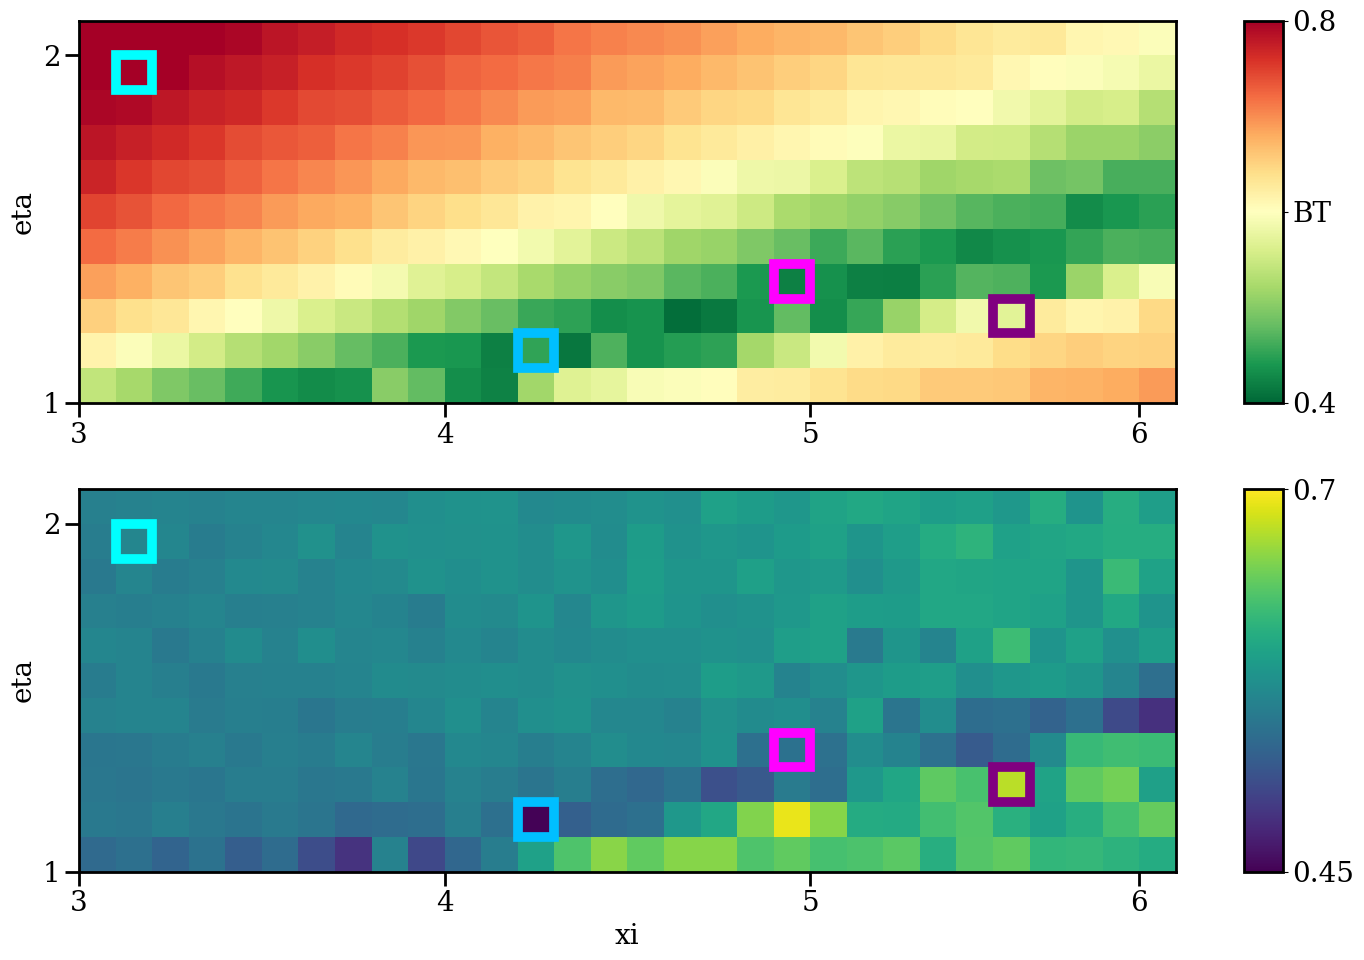

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Payoff_mat'

plt.rc('font', family='serif', size=30)


def Generator(eta1,eta2):
    A=torch.load('Payoff-eta_'+str(eta1)+'eta_2'+str(eta2)+'.pt')#,map_location=torch.device('cpu'))
    M=10
    N=500
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    plt.rc('font', family='serif', size=18)
    terminal_time=400
    mu,nu=QRE(A,taw=.1)
    env = Opinon_w_media_9(device=device, N=N,
                                    M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                                    duration=terminal_time,h=torch.tensor(.1),
                                    num_batches=200,eta=eta1, eta2=eta2,
                                    bet1=3,bet2=2)
    run_simulation(torch.multinomial((mu / mu.sum()).view(-1), num_samples=env.batch_size, replacement=True),
                  torch.multinomial((nu / nu.sum()).view(-1), num_samples=env.batch_size, replacement=True),
                  env)
    x, s, c = env.state[:N, :].cpu().flatten().numpy(), env.s.cpu().flatten().numpy(), env.state[N:, :].cpu().numpy()
    return x,s,c



from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=0.4, vcenter=5/9, vmax=0.8)


C=torch.load('mean_c.pt')
Bibmodal=torch.load('Bibmodal_b.pt')
fig, axes = plt.subplots(2,1,figsize=(15, 10))
ax=axes[0]
# cax = ax.imshow(Bibmodal, cmap=cm.RdBu)
# cax = ax.imshow(Bibmodal,vmin=0.4,vcenter=5/9, vmax=0.8,cmap=cm.RdYlGn_r)
cax=ax.pcolormesh(Bibmodal, cmap="RdYlGn_r", norm=divnorm)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[0.4, 5/9 ,.8],aspect=10)
cbar.ax.set_yticklabels(['0.4', 'BT', '0.8'])
ax.set_xticks([0,10,20,29],[3,4,5,6])
ax.set_yticks([0,10],[1,2])

ax.set_ylabel('eta')

square = plt.Rectangle((1, 9), 1, 1, edgecolor='cyan', facecolor='none',lw=7)
ax.add_patch(square)



square = plt.Rectangle((12, 1), 1, 1, edgecolor='deepskyblue', facecolor='none',lw=7)
ax.add_patch(square)

square = plt.Rectangle((19, 3), 1, 1, edgecolor='magenta', facecolor='none',lw=7)
ax.add_patch(square)

square = plt.Rectangle((25, 2), 1, 1, edgecolor='purple', facecolor='none',lw=7)
ax.add_patch(square)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(axis='x', which='major', labelsize=30, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
cbar.outline.set_linewidth(2)



# ------------------
ax=axes[1]
divnorm=colors.TwoSlopeNorm(vmin=0.4,vcenter=0.55, vmax=0.7)
cax=ax.pcolormesh(C, cmap="viridis", norm=divnorm)
cbar = fig.colorbar(cax, ticks=[0.4 ,.7],aspect=10)
cbar.ax.set_yticklabels(['0.45', '0.7'])


ax.set_xticks([0,10,20,29],[3,4,5,6])
ax.set_yticks([0,10],[1,2])
square = plt.Rectangle((1, 9), 1, 1, edgecolor='cyan', facecolor='none',lw=7)
ax.add_patch(square)

square = plt.Rectangle((12, 1), 1, 1, edgecolor='deepskyblue', facecolor='none',lw=7)
ax.add_patch(square)

square = plt.Rectangle((19, 3), 1, 1, edgecolor='magenta', facecolor='none',lw=7)
ax.add_patch(square)

square = plt.Rectangle((25, 2), 1, 1, edgecolor='purple', facecolor='none',lw=7)
ax.add_patch(square)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(axis='x', which='major', labelsize=20, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=20, width=2, length=10)
cbar.outline.set_linewidth(2)
ax.set_xlabel('xi')
ax.set_ylabel('eta')

plt.tight_layout()
plt.savefig("eta-xi.svg",dpi=300)
plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Eta1=np.arange(1,2.1,0.1)
Eta2=np.arange(3,6,0.1)
eta1=Eta1[1]
eta2=Eta2[9]

colors=['cyan','deepskyblue','magenta','purple']
ctr=0
fig, axes = plt.subplots(1,4,figsize=(10, 5))
axes=axes.flatten()
for i,j in [(1,9),(12,1),(19,3),(25,2)]:
    ax=axes[ctr]
    x,s,c=Generator(Eta1[j],Eta2[i])
    sns.kdeplot(x=x, color=colors[ctr], fill=True, ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([0, 1.2])
    ax.tick_params(axis='x', which='major', labelsize=20, width=2, length=10)
    # ax.tick_params(axis='y', which='major', labelsize=20, width=2, length=10)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.xaxis.set_ticks([-1, 0, 1])
    ax.set_title(f'eta: {Eta1[j]:0.1f},   xi:{Eta2[i]:0.1f}')
    if ctr!=0:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks([])
        ax.set_ylabel('')
    if ctr==0:
        ax.spines['left'].set_visible(True)
        ax.yaxis.set_ticks([0, 1])
        ax.tick_params(axis='y', which='major', labelsize=20, width=2, length=10)
        ax.set_ylabel('Density')

    ax.set_xlabel('X')
    ctr+=1

plt.tight_layout()
plt.savefig("eta-xi-dists.svg",dpi=300)
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Eta1=np.arange(1,2.1,0.1)
Eta2=np.arange(3,6,0.1)
eta1=Eta1[1]
eta2=Eta2[9]

colors=['cyan','deepskyblue','magenta','purple']
ctr=0
fig, axes = plt.subplots(1,4,figsize=(10, 3))
axes=axes.flatten()
for i,j in [(1,9),(12,1),(19,3),(25,2)]:
    ax=axes[ctr]
    x,s,c=Generator(Eta1[j],Eta2[i])
    # sns.kdeplot(x=x, color=colors[ctr], fill=True, ax=ax)
    ax.plot(np.linspace(-1,1,10),c.mean(axis=1),'-o',c=colors[ctr],linewidth=4,markersize=10)
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', which='major', labelsize=20, width=2, length=10)
    ax.tick_params(axis='y', which='major', labelsize=20, width=2, length=10)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.xaxis.set_ticks([-1, 0, 1])
    ax.set_title(f'eta: {Eta1[j]:0.1f},   xi:{Eta2[i]:0.1f}')
    if ctr!=0:
        # ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks([])
        ax.set_ylabel('')
    if ctr==0:
        ax.yaxis.set_ticks([0, 1])
        ax.tick_params(axis='y', which='major', labelsize=20, width=2, length=10)
        ax.set_ylabel('Crediblity')

    ax.set_xlabel('X')
    ctr+=1

plt.tight_layout()
plt.savefig("eta-xi-credits.svg",dpi=300)
plt.show()





## Xi-eta2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/UT/Credit-Bias Project/Payoff_mat
/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/xi-eta


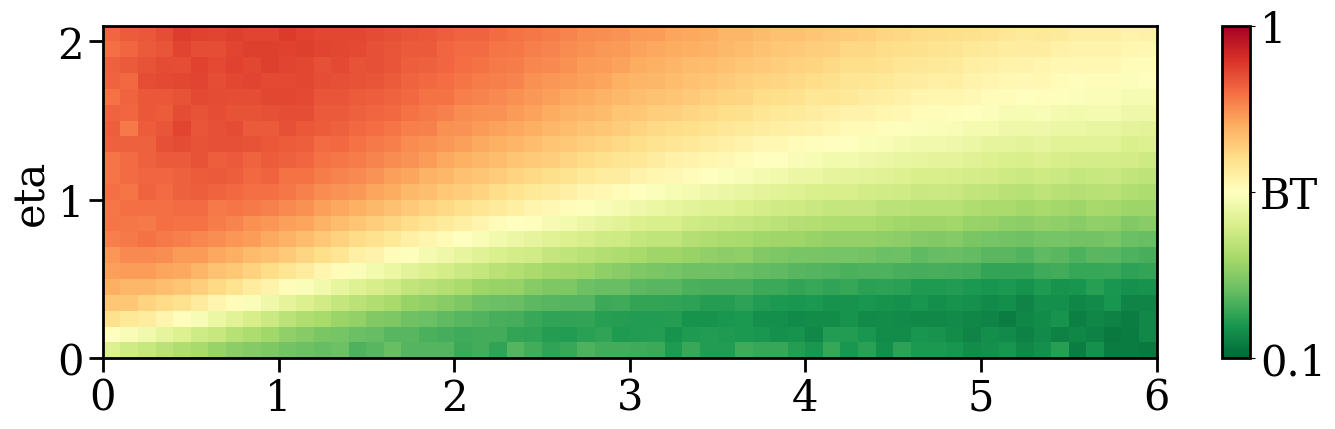

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Payoff_mat'

plt.rc('font', family='serif', size=30)





from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=.1, vcenter=5/9, vmax=1)


C=torch.load('mean_c-final.pt')
Bibmodal=torch.load('Bibmodal_b-final.pt')
fig, ax = plt.subplots(1,1,figsize=(15, 5))

# cax = ax.imshow(Bibmodal, cmap=cm.RdBu)
# cax = ax.imshow(Bibmodal,vmin=0.4,vcenter=5/9, vmax=0.8,cmap=cm.RdYlGn_r)
cax=ax.pcolormesh(Bibmodal, cmap="RdYlGn_r", norm=divnorm)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[0.1, 5/9, 1],aspect=12)
cbar.ax.set_yticklabels(['0.1', 'BT', '1'])
ax.set_xticks([0,10,20,30,40,50,60],[0,1,2,3,4,5,6])
ax.set_yticks([0,10,20],[0,1,2])

ax.set_ylabel('eta')

# square = plt.Rectangle((1, 9), 1, 1, edgecolor='cyan', facecolor='none',lw=7)
# ax.add_patch(square)



# square = plt.Rectangle((12, 1), 1, 1, edgecolor='deepskyblue', facecolor='none',lw=7)
# ax.add_patch(square)

# square = plt.Rectangle((19, 3), 1, 1, edgecolor='magenta', facecolor='none',lw=7)
# ax.add_patch(square)

# square = plt.Rectangle((25, 2), 1, 1, edgecolor='purple', facecolor='none',lw=7)
# ax.add_patch(square)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(axis='x', which='major', labelsize=30, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=30, width=2, length=10)
cbar.outline.set_linewidth(2)
plt.tight_layout()
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/xi-eta'
plt.savefig("eta-xi-dists-final.svg",dpi=300)
plt.show()


In [ ]:
def QRE(A,taw=0.1):
    Ar=A/A.abs().max()
    Mu=[]
    Nu=[]
    for j in range(20):
        mu=torch.softmax(torch.rand((Ar.shape[0],1),device=device),dim=0)
        nu=torch.softmax(torch.rand((Ar.shape[0],1),device=device),dim=0)
        mub=mu
        nub=nu
        eta=taw/30
        for i in range(5*10**4):
            mut=mu
            nut=nu
            mub=mu.pow(1-eta*taw)*torch.exp(eta*Ar@nub)/(mu.pow(1-eta*taw)*torch.exp(eta*Ar@nub)).sum()
            nub=nu.pow(1-eta*taw)*torch.exp(-eta*Ar.t()@mub)/(nu.pow(1-eta*taw)*torch.exp(-eta*Ar.t()@mub)).sum()
            mu=mu.pow(1-eta*taw)*torch.exp(eta*Ar@nub)/(mu.pow(1-eta*taw)*torch.exp(eta*Ar@nub)).sum()
            nu=nu.pow(1-eta*taw)*torch.exp(-eta*Ar.t()@mub)/(nu.pow(1-eta*taw)*torch.exp(-eta*Ar.t()@mub)).sum()
            DG=nut.t()@Ar@mu-nu.t()@Ar@mut
            if DG.abs().mean(dim=1).item()< 1e-7:
                  Mu.append(mu.cpu().numpy())
                  Nu.append(nu.cpu().numpy())
                  break

    print(f"Dulity Gap taw {i:.0f}: {DG.item():.2e}")
    return np.array(Mu).mean(axis=0).flatten(),np.array(Nu).mean(axis=0).flatten()

def Generator(eta1=1,eta2=2):

    A=torch.load('Payoff-eta_200'+str(eta1)+'eta_2'+str(eta2)+'.pt')#,map_location=torch.device('cpu'))
    M=10
    N=500
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    terminal_time=200
    mu,nu=QRE(A,taw=.1)
    mu=torch.tensor(mu)
    nu=torch.tensor(nu)
    env = Opinon_w_media_9(device=device, N=N,
                                    M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                                    duration=terminal_time,h=torch.tensor(.1),
                                    num_batches=100,eta=eta1, eta2=eta2,
                                    bet1=3,bet2=2)
    env.reset()
    reward, done = env.dyn_step(torch.multinomial((mu / mu.sum()).to(device),num_samples=env.batch_size, replacement=True),
                                torch.multinomial((nu / nu.sum()).to(device),num_samples=env.batch_size, replacement=True))
    # run_simulation(torch.multinomial((mu / mu.sum()).view(-1), num_samples=env.batch_size, replacement=True),
                  # torch.multinomial((nu / nu.sum()).view(-1), num_samples=env.batch_size, replacement=True),
                  # env)
    x, s, c = env.state[:N, :].cpu().flatten().numpy(), env.s.cpu().flatten().numpy(), env.state[N:, :].cpu().numpy()
    return x,s,c

In [ ]:
import numpy as np
from tqdm import tqdm  # Ensure tqdm is imported


Eta1 = np.arange(0, 2.1, 0.1)
Eta2 = np.arange(0, 6, 0.1)
X = {}
# Loop over selected indices of Eta1
for j in tqdm([0,5,10,15,20]):  # Adjusted indices to match the length of Eta1
    X[j] = {}  # Initialize sub-dictionary for each j
    for i in [10,30,50]:  # Adjusted to loop over the length of Eta2
        x, s, c = Generator(Eta1[j], Eta2[i])  # Uncommented and assumed to be correct
        X[j][i] = {'x': x, 's': s, 'c': c}
torch.save(X, 'Data-final200.pt')

  0%|          | 0/5 [00:00<?, ?it/s]

Dulity Gap taw 1582: 9.31e-08
Dulity Gap taw 12206: 9.88e-08
Dulity Gap taw 9079: 9.90e-08


 20%|██        | 1/5 [07:38<30:33, 458.48s/it]

Dulity Gap taw 13735: 9.31e-08
Dulity Gap taw 16463: 9.97e-08
Dulity Gap taw 14868: 9.97e-08


 40%|████      | 2/5 [18:07<27:55, 558.64s/it]

Dulity Gap taw 17739: 9.78e-08
Dulity Gap taw 15290: 9.69e-08
Dulity Gap taw 15303: 9.97e-08


 60%|██████    | 3/5 [29:53<19:55, 597.96s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'Payoff-eta_2001.5eta_21.0.pt'

/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/xi-eta


  0%|          | 0/3 [00:00<?, ?it/s]

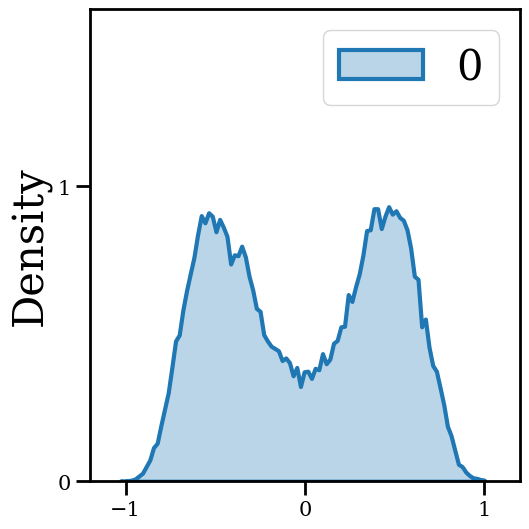

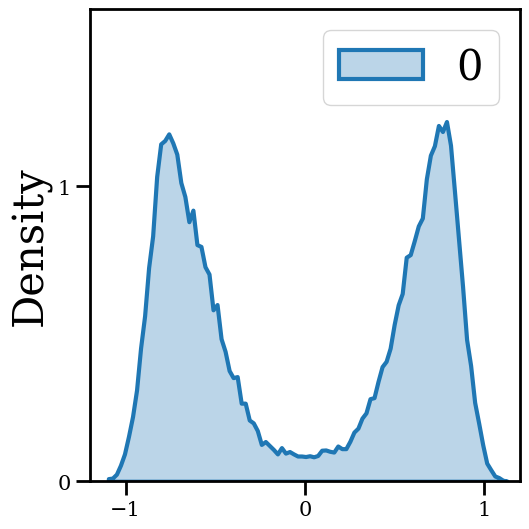

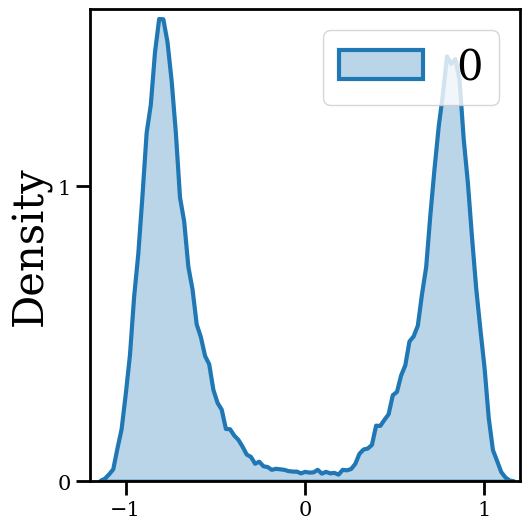

 33%|███▎      | 1/3 [00:00<00:01,  1.50it/s]

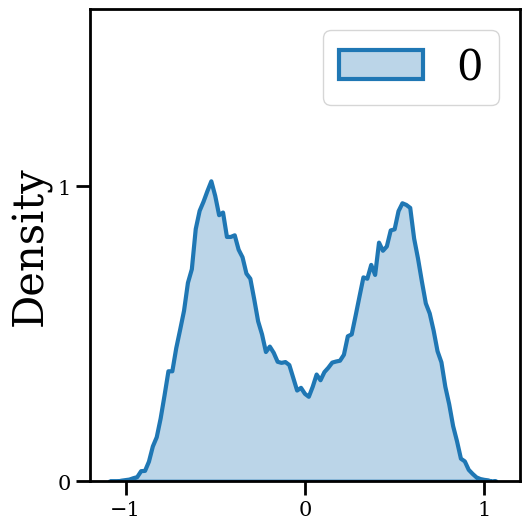

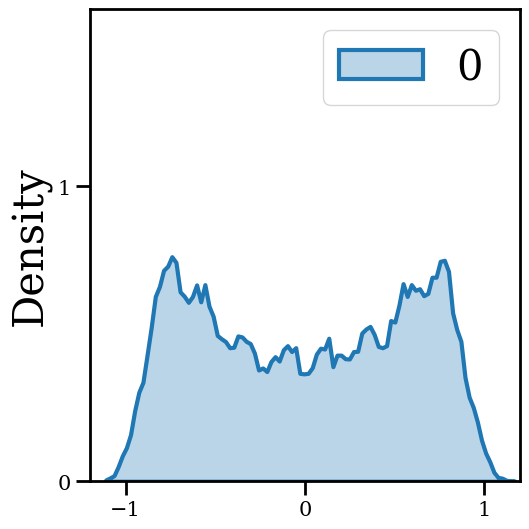

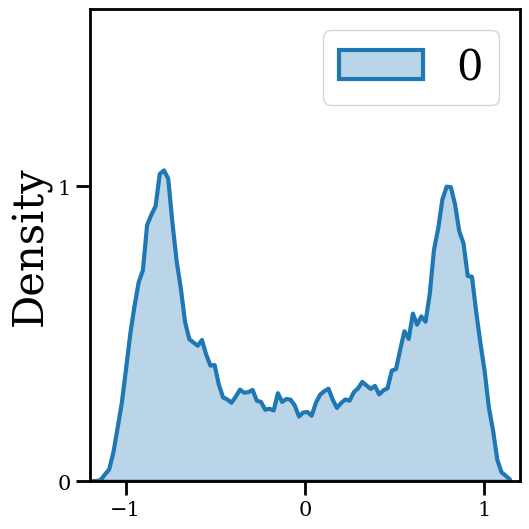

 67%|██████▋   | 2/3 [00:01<00:00,  1.43it/s]

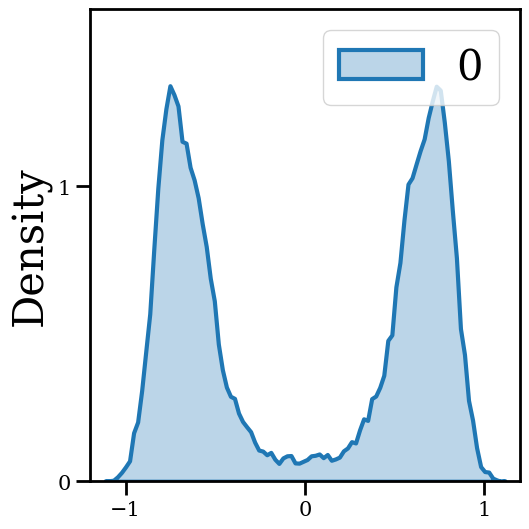

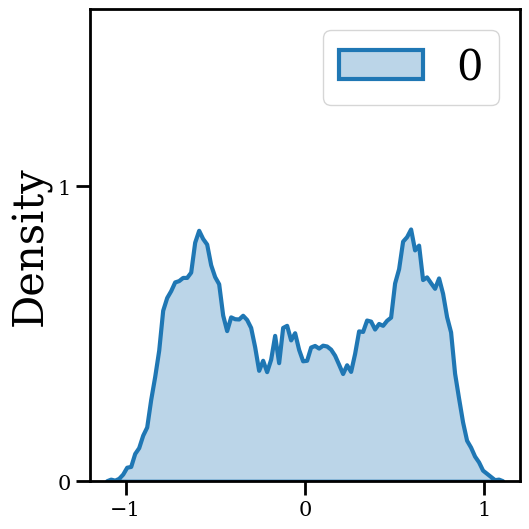

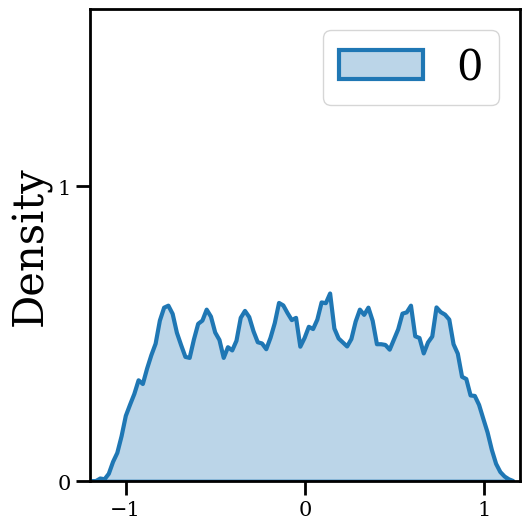

100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define a color map for each i value
color_map = {
    10: 'pink',      # Pink shades for i=10
    30: 'darkcyan',  # Dark cyan shades for i=30
    50: 'orange'     # Orange shades for i=50
}
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/xi-eta'

for j in tqdm([0, 5, 10]):
    for i in [10, 30, 50]:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        sns.histplot([X[j][i]['x']], bins=100, element="poly", stat="density",
                      alpha=.3,linewidth=3)  # Apply color and alpha
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([0, 1.6])
        ax.set_xticks([-1, 0, 1])
        ax.set_yticks([0, 1])
        ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
        ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        plt.tight_layout()
        plt.savefig(str(i)+'_'+str(j)+'.svg')
        plt.show()
        # Increase alpha to make the next plot lighter


plt.show()


In [ ]:
import scipy.stats as stats

def bimodality_coefficient(data):
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data,fisher=False)
    bimodality_coefficient = (skewness**2 + 1) / kurtosis
    # print(kurtosis,skewness)
    return bimodality_coefficient
    bimodality_coefficient = arles_bimodality_coefficient(x)
print(bimodality_coefficient(X[0][10]['x']))
print(bimodality_coefficient(X[5][10]['x']))
print(bimodality_coefficient(X[10][10]['x']))

print(bimodality_coefficient(X[0][30]['x']))
print(bimodality_coefficient(X[5][30]['x']))
print(bimodality_coefficient(X[10][30]['x']))



0.6178567302847914
0.634059362287456
0.8220406562879904
0.794208636111312
0.6094789224048441
0.6098113514895371


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100%|██████████| 3/3 [00:00<00:00, 12.04it/s]


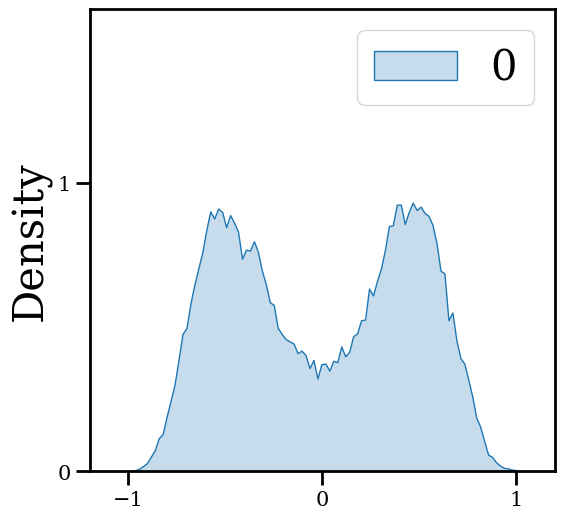

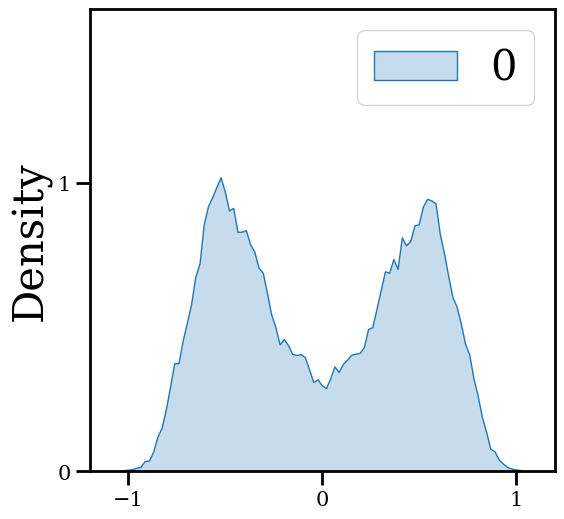

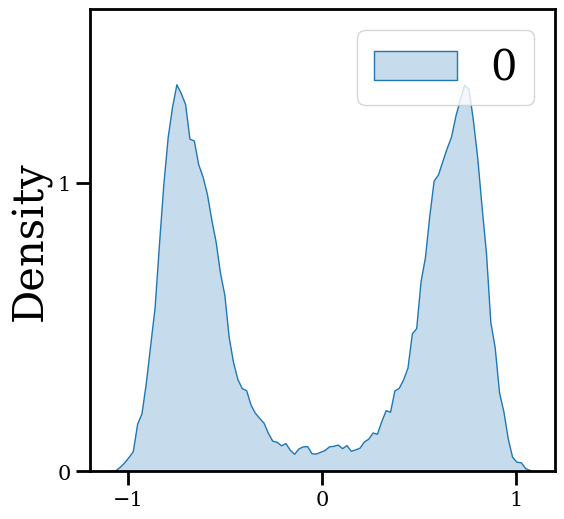

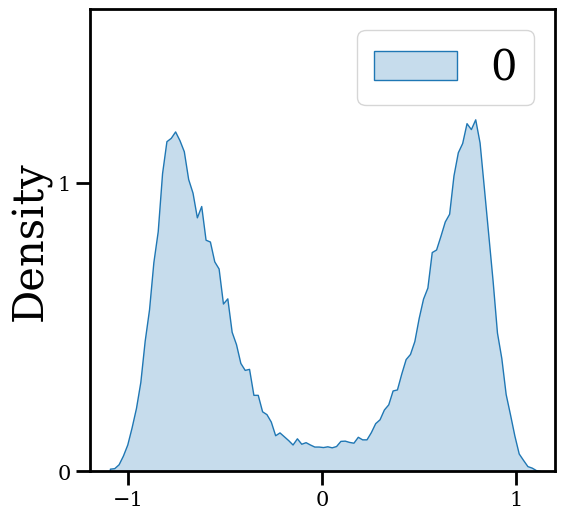

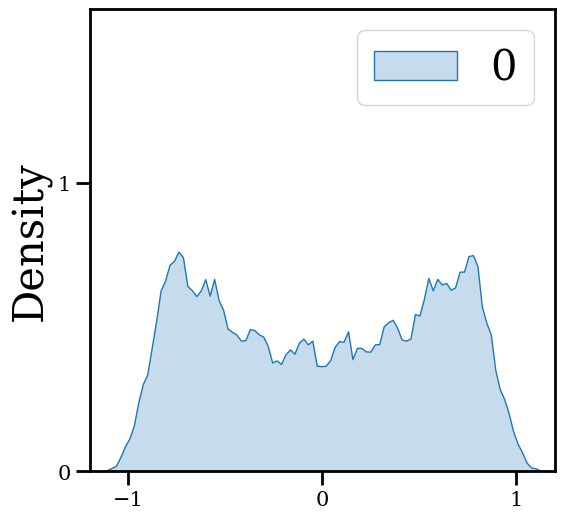

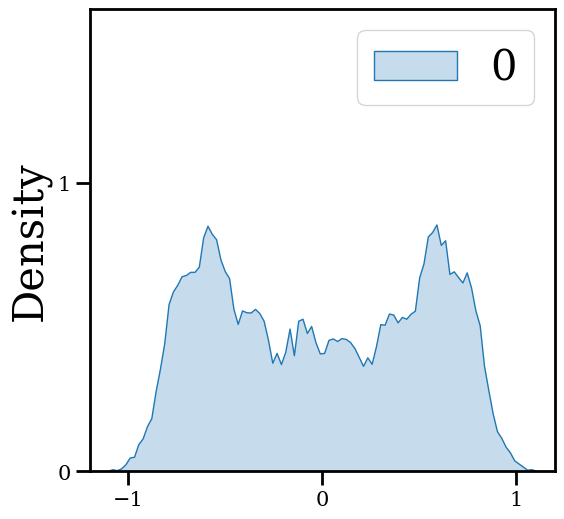

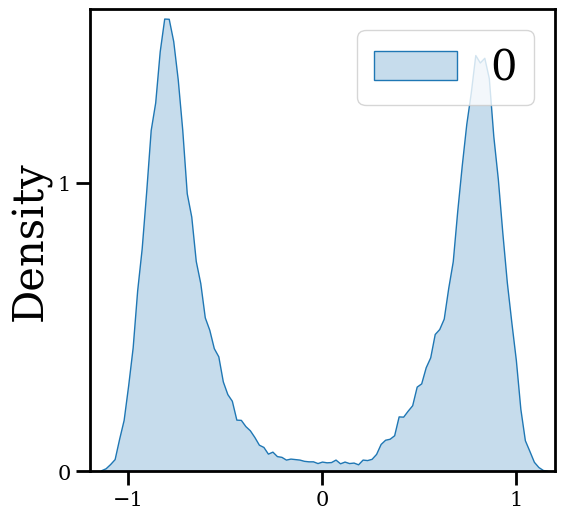

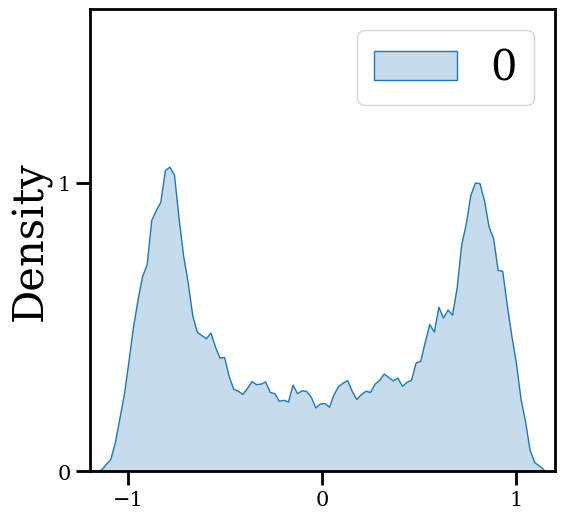

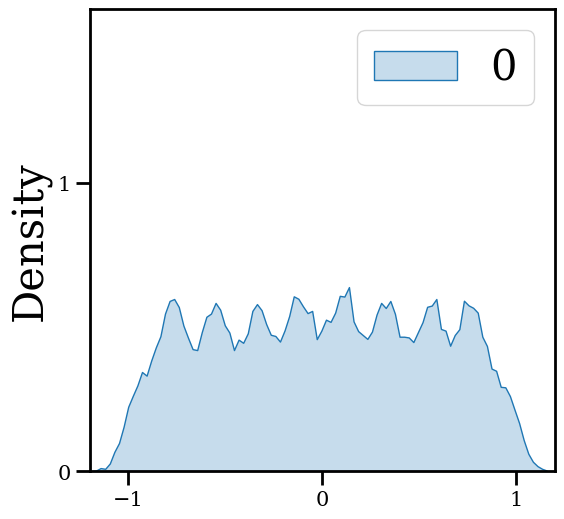

In [ ]:
for i in [10,30,50]:
  for j in tqdm([0,5,10]):  # Adjusted indices to match the length of Eta1
    # plt.hist(X[0][10]['x'],bins=100)
    fig, ax = plt.subplots(1,1,figsize=(6, 6))
    sns.histplot([X[j][i]['x']],bins=100,element="poly",stat="density")
    ax.set_xlim([-1.2 ,1.2])
    ax.set_ylim([0, 1.6])
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0, 1])
    ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
    ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

In [ ]:
x,s,c=Generator(Eta1[j],Eta2[i])

Dulity Gap taw 0: 1.83e-03
Dulity Gap taw 5083: 9.69e-08


# Opinion-time

In [ ]:
%cd '/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/Op-dyn'

/content/gdrive/MyDrive/UT/Credit-Bias Project/Final Figures/Op-dyn


In [ ]:
import torch
import torch.multiprocessing as mp
import time
import numpy as np

class Opinon_w_media(torch.nn.Module):
    def __init__(self, device, N=1000, M=10, terminal_time=500,
                 bM=5, b=25, noise_level=0.1, duration=50, eta=1, eta2=2,
                 h=torch.tensor(0.1),num_batches=10,bet1=3,bet2=2):
        super().__init__()
        self.batch_size = num_batches
        self.device = device
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        Beta = torch.distributions.beta.Beta(bet1, bet2)
        self.s = Beta.sample(sample_shape=(self.N,self.batch_size)).to(self.device)
        self.ym = torch.linspace(-1, 1, steps=self.M).to(self.device)
        self.noise_level = noise_level
        self.bM = bM
        self.b = b
        self.duration = duration
        self.eta = eta
        self.eta2 = eta2
        self.h = h.to(self.device)
        self.t=0
        self.action_dim=9
        self.pi=torch.tensor(np.pi,device=self.device)





    def reset(self):
        self.state = torch.cat([torch.rand((self.N,self.batch_size), device=self.device) * 2 - 1,
                                torch.ones((self.M,self.batch_size), device=self.device)])
        return self.state

    def dyn_step(self):
        rewards = torch.zeros((self.batch_size,), device=self.device)
        dones = torch.zeros((self.batch_size,), device=self.device, dtype=torch.bool)
        x, c= self.state[:self.N], self.state[self.N:]
        X=torch.zeros((self.terminal_time,self.N,self.batch_size),device=self.device)
        X[0,:,:]=x
        t=self.t
        gam=0.98
        rewards=0
        self.AEm=torch.zeros((self.N,self.batch_size,self.M),device=self.device)
        self.AEm_abs=torch.zeros((self.N,self.batch_size,self.M),device=self.device)
        for i in range(self.terminal_time):
            X[i,:,:]=x
            DM = self.ym-x[:,:,None]
            D = x - x[:, None]
            actions=torch.bernoulli(0.95-0.000000000005*env.ym**2).to(self.device)[None,:]
            # actions=torch.bernoulli(0.5+0.000000085*env.ym**2).to(self.device)[None,:]
            # actions=torch.bernoulli(torch.rand(self.M)).to(self.device)[None,:]
            # u_actions = actions[:int(self.M/2)]
            # v_actions =  actions[int(self.M/2):]
            # actions = torch.cat([u_actions, v_actions],dim=1)
            eta = self.eta
            eta2 = self.eta2
            AM = torch.exp(-self.bM * (1 + eta * actions[None,:,:]) * (1 + eta2 * (1 - c.t()[None,:,:])*(1-self.s[:,:,None])) * torch.abs(DM))
            self.AEm_abs += torch.exp(-self.bM * torch.abs(DM))* (1-actions[None,:,:])
            self.AEm += torch.exp(-self.bM * (1 + eta * actions[None,:,:]) * (1 + eta2 * (1 - c.t()[None,:,:])*(1-self.s[:,:,None])) * torch.abs(DM))* (1-actions[None,:,:])
            A = torch.exp(-self.b * torch.abs(D))
            t += 1
            # c = (c * (t - 1) + actions.t()) / t
            c= c*(gam)+actions.t()*(1-gam)
            x += self.h * ((torch.sum(A * D, dim=1) / torch.sum(A, dim=1)) + (torch.sum(AM * DM, dim=2) / torch.sum(AM, dim=2)))
            x += torch.sqrt(self.h) * torch.normal(0, self.noise_level, size=(self.N,self.batch_size), device=self.device)
            rewards += -1*torch.sin(x*self.pi/2).pow(5).sum().to(self.device)

        self.state=torch.cat([x,c])
        self.X=X
        self.c=c
        # print(c.mean(dim=1))
        self.t=t
        dones = dones | (t >= self.terminal_time)
        self.AM=AM
        return rewards, dones




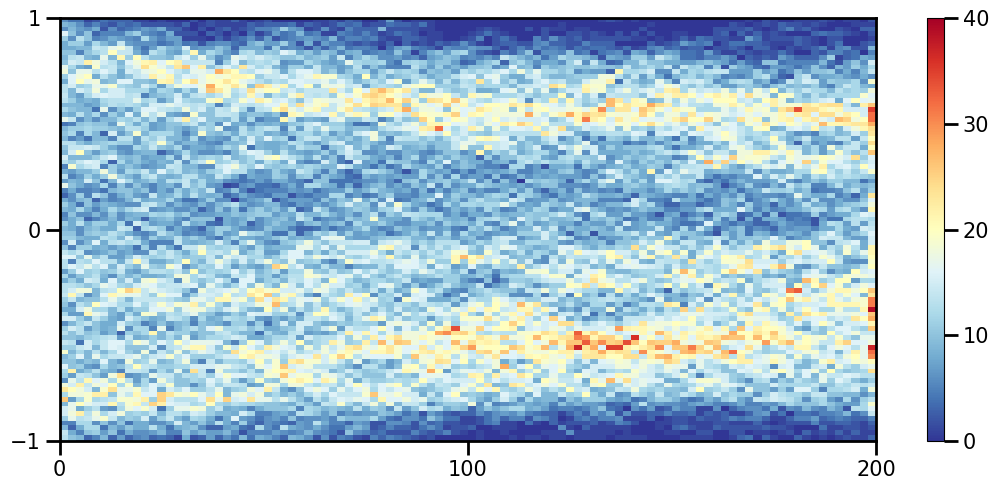

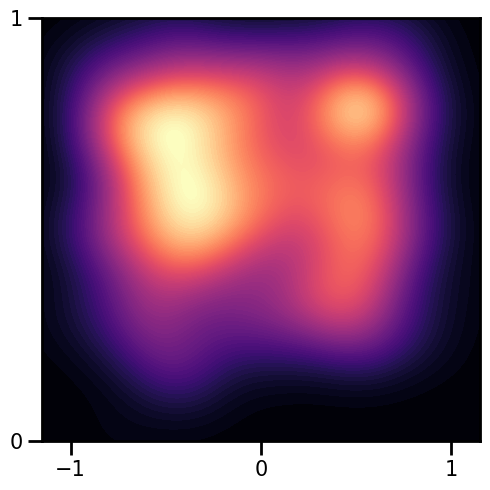

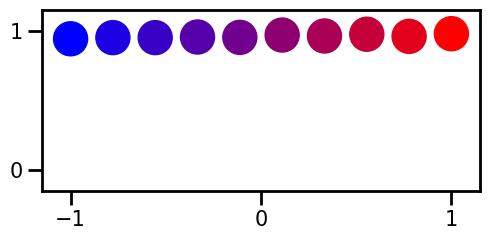

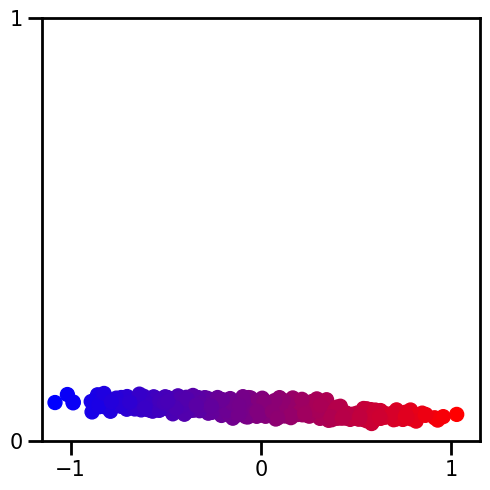

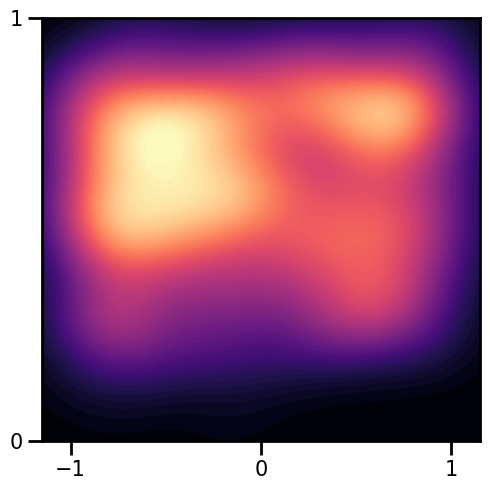

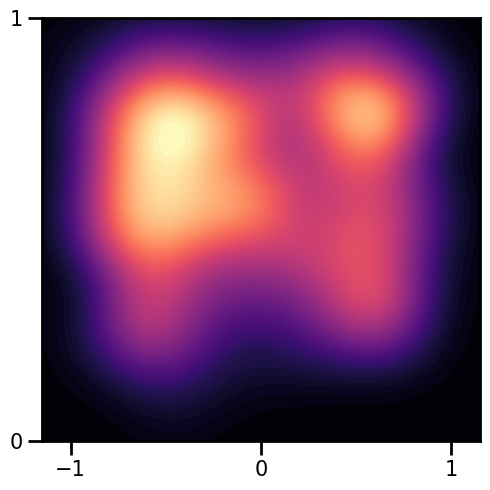

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)


plt_type='Normal'
M=10
N=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
terminal_time=201
env = Opinon_w_media(device=device, N=N,
                              M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                              duration=terminal_time,h=torch.tensor(.1),
                              num_batches=1,eta=1, eta2=2,
                              bet1=3,bet2=2)
env.reset()
reward, done = env.dyn_step()
X=env.X.squeeze().cpu().numpy()
Tvec=np.arange(X.shape[0])



fig,ax=plt.subplots(figsize=(11,5))
T=np.ones((1,N))*np.arange(X.shape[0])[:,None]
cax=sns.histplot(x=T.flatten(),y=X.flatten(),fill=True,cmap="RdYlBu_r",bins=100,thresh=None,ax=ax)
quadmesh = cax.collections[0]
quadmesh.set_clim(0, 40)
cbar = plt.colorbar(cax.collections[0], ax=ax,aspect=25)
cbar.ax.tick_params(labelsize=15, width=2, length=10)
cbar.ax.set_yticks([0,10,20,30,40])


ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_ylim(-1, 1)
ax.set_xlim(0, terminal_time-1)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([0,100,200])


plt.tight_layout()
plt.savefig("op_hist"+plt_type+".svg",dpi=300)
plt.show()


time_indices = [ -1]
fig, axes = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
ax=axes
# for ax, t_idx in zip(axes, time_indices):
t_idx=-1
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)




plt.tight_layout()
plt.savefig("xs_kde200"+plt_type+".svg",dpi=300)
plt.show()




# cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
# cmap = plt.cm.RdYlBu_r

fig,ax=plt.subplots(figsize=(5,2.5))
ax.scatter(env.ym.cpu(),env.c.cpu(),600,c=env.ym.cpu(),cmap=cmap,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.savefig("cx_circ"+plt_type+".svg",dpi=300)
plt.show()



fig,ax=plt.subplots(figsize=(5,5))


x=env.X.squeeze().cpu().numpy()[-1,:]
ax.scatter(y=env.AEm_abs.sum(axis=2).cpu().flatten().numpy()/(terminal_time-1),x=x,c=x,cmap=cmap,s=100,alpha=1)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.savefig("Ex_"+plt_type+".svg",dpi=300)
plt.show()



t_idx=0
fig, ax = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.savefig("xs_kde000"+plt_type+".svg",dpi=300)
plt.show()




t_idx=100
fig, ax = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.savefig("xs_kde100"+plt_type+".svg",dpi=300)
plt.show()


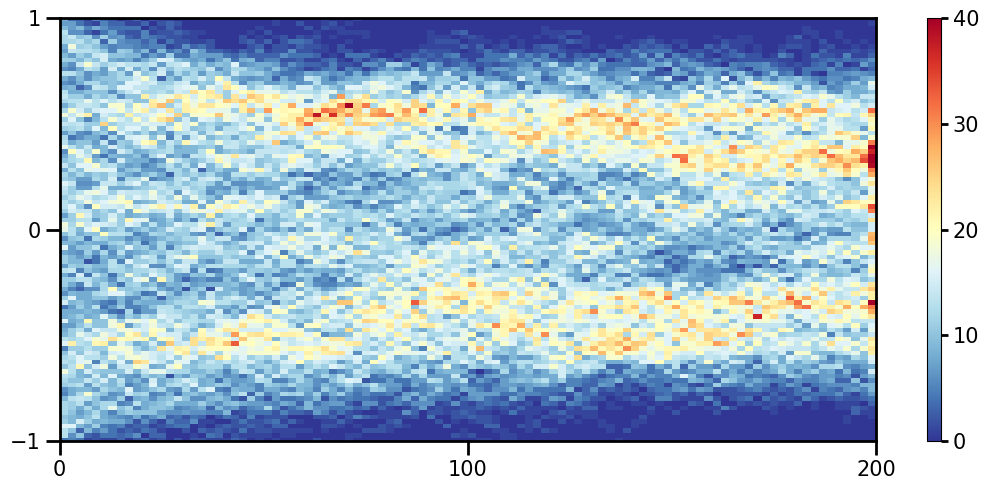

In [ ]:
fig,ax=plt.subplots(figsize=(11,5))
cax=sns.histplot(x=T.flatten(),y=X.flatten(),fill=True,cmap="RdYlBu_r",bins=100,thresh=None,ax=ax)

quadmesh = cax.collections[0]
quadmesh.set_clim(0, 40)

cbar = plt.colorbar(cax.collections[0], ax=ax,aspect=30)
cbar.ax.tick_params(labelsize=15, width=2, length=5)
cbar.ax.set_yticks([0,10,20,30,40])



ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 200)
ax.set_xlim(0, terminal_time-1)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([0,100,200])
plt.tight_layout()
# plt.savefig("op_hist"+plt_type+".svg",dpi=300)
plt.show()

<Axes: ylabel='Density'>

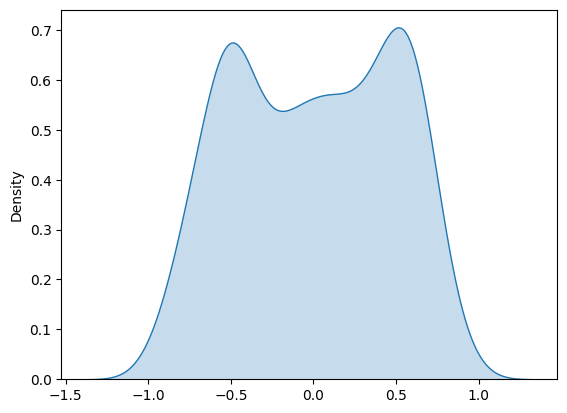

In [ ]:
sns.kdeplot(X[50,:],fill=True,)


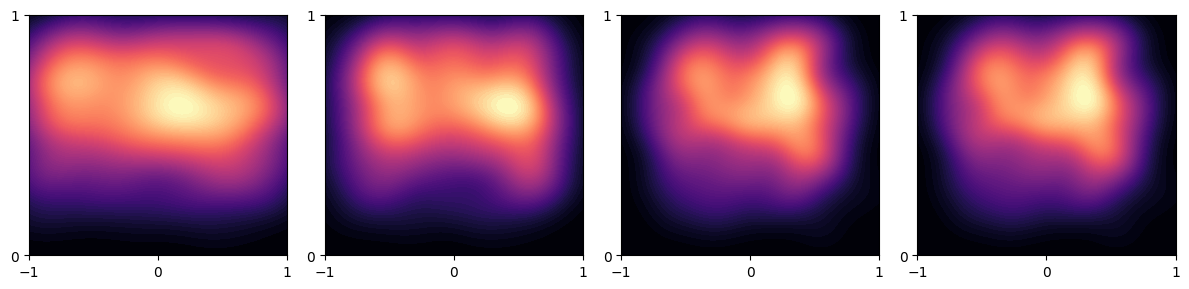

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Assuming your environment and X data is set up and loaded as previously described


fig, axes = plt.subplots(1, 4, figsize=(12, 3))  # Adjust the figure size as needed
time_indices = [0, 50, 200, -1]
for ax, t_idx in zip(axes, time_indices):
    sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0, 1])
    # ax.set_title(f'Time {t_idx}')

# Ensure layout does not overlap and everything is visible
plt.tight_layout()
plt.show()


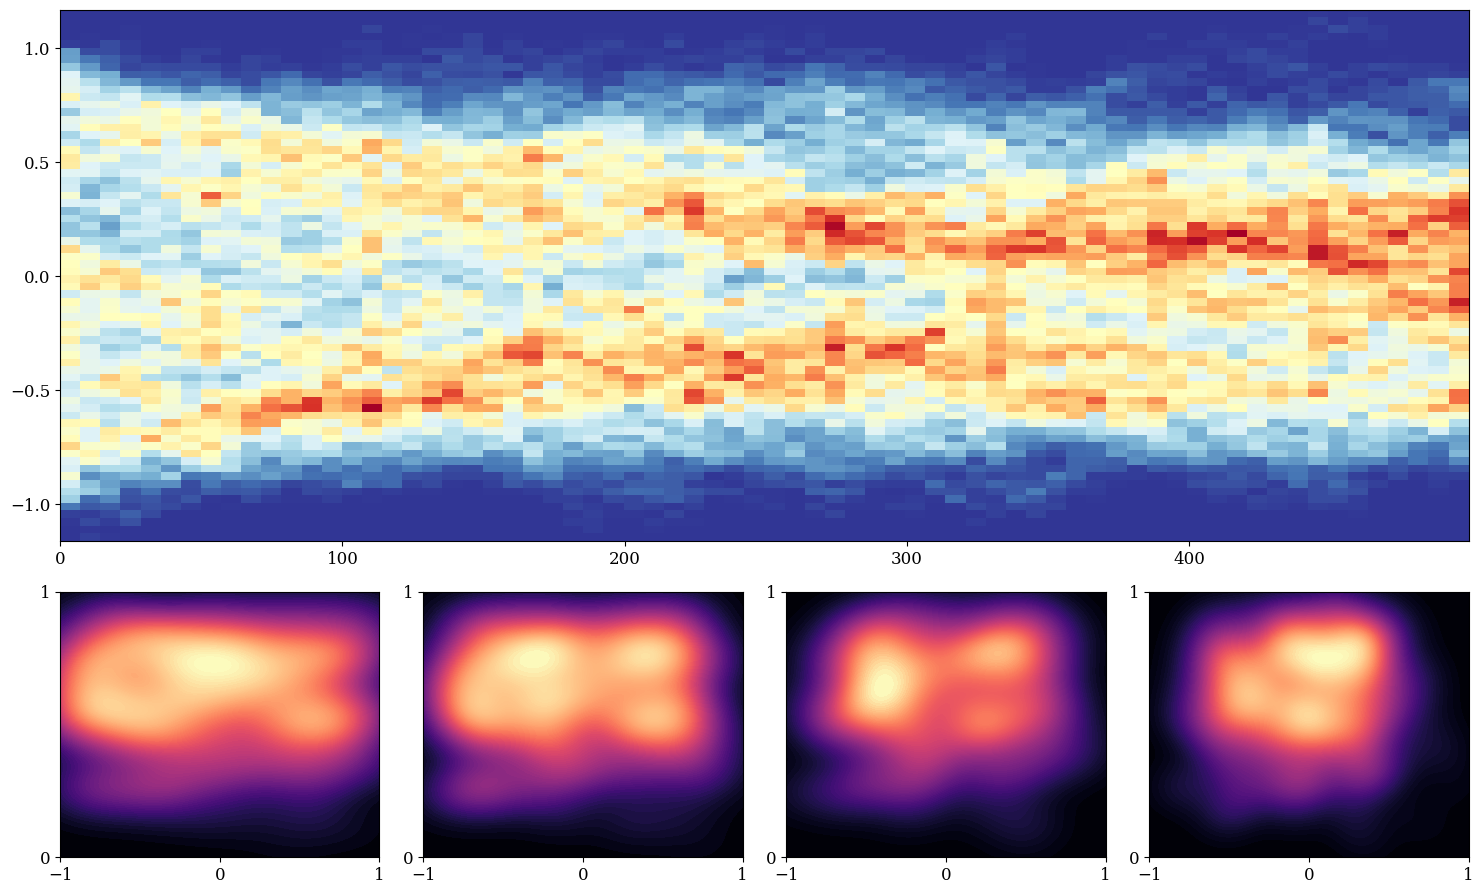

In [ ]:

# Create the figure layout
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 4, height_ratios=[2, 1, 1])

# Create the main histogram plot
ax_hist = fig.add_subplot(gs[0, :])
T = np.ones((1, N)) * np.arange(X.shape[0])[:, None]
cax = sns.histplot(x=T.flatten(), y=X.flatten(), fill=True, cmap='RdYlBu_r', bins=70, thresh=None, ax=ax_hist)

# Access the QuadMesh object from the collections of the ax_hist to create colorbar
# quad_mesh = ax_hist.collections[0]
# cbar = fig.colorbar(quad_mesh, ax=ax_hist, ticks=[0, .5, 1], aspect=10)

# Define the times at which to plot the KDEs
time_indices = [0, 50, 200, -1]

# Create the KDE plots
kde_axes = [fig.add_subplot(gs[1, i]) for i in range(4)]
for ax, t_idx in zip(kde_axes, time_indices):
    sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([0, 1])
    # ax.set_title(f'Time {t_idx}')

plt.tight_layout()
plt.show()